In [72]:
from data_io.loader.data_loader import DataLoader, WeatherData
from data_io.fetch.fetch_weather_data import fetch_weather_data_for_year

In [73]:
dl = DataLoader()

### Data Sanity: Resolution of weather stations

First we check the resolution of the weather data. Can we use the weather data to analyze local weather phenomenons?
Are we able to get different data for the counting stations? 

In [74]:
station_location = {}
for station in dl.get_bicyle_stations():
  station_location[station] = dl.get_bicycle_location(station)
station_location

{'Ziegelhäuser Landstraße': (49.41925887156788, 8.725964292061843),
 'Bahnstadtpromenade': (49.39770881177102, 8.672678949737529),
 'Berliner Straße Querschnitt': (49.42197166293551, 8.677004169311507),
 'Gaisbergstraße': (49.406723, 8.69424),
 'Eppelheimer Str. Querschnitt': (49.40470762611589, 8.64976028739517),
 'Kurfürstenanlage Querschnitt': (49.406487543497484, 8.68846627824381),
 'Plöck': (49.40913, 8.698543),
 'Ernst-Walz-Brücke West - alt': (49.410425822073066, 8.676603857406642),
 'Liebermannstraße': (49.396327404063875, 8.688098472233529),
 'Schlierbacher Landstraße': (49.414704846474805, 8.71839594333201),
 'Thedor-Heuss-Brücke Querschnitt': (49.41179170458847, 8.692717007248563),
 'Hardtstraße': (49.3886384101731, 8.676692652778558),
 'Rohrbacher Straße Querschnitt': (49.397682399063164, 8.689534722556413),
 'Ernst-Walz-Brücke Querschnitt': (49.40953402601704, 8.676711154365599),
 'Mannheimer Straße': (49.4118, 8.65914)}

Lets check what the response of the API is giving us

In [ ]:
import requests

api_reponses = {}
for station, location in station_location.items():
  lat, lon = location

  params = {
      "latitude": lat,
      "longitude": lon,
      "start_date": "2024-01-01",
      "end_date": "2024-01-02",
      "hourly": "temperature_2m",
  }

  r = requests.get("https://archive-api.open-meteo.com/v1/archive", params=params)
  meta = r.json()
  api_reponses[station] = (meta["latitude"], meta["longitude"])
api_reponses

As we can see nearly all stations fall in the same grid cell. Only Berliner Straße Querschnitt is in a different cell. 
Therefore we get the same values for all stations apart from Berliner Straße Querschnitt. 
We can also see this in the following visualization. 

In [75]:

import polars as pl
weather_data = {}
for station, coord in station_location.items():
  lat = coord[0]
  lon = coord[1]
  df = fetch_weather_data_for_year(year=2024, start_month=1, end_month=1, start_day=1, end_day=20, latitude=lat, longitude=lon)

  df = df.with_columns([
            pl.col("timestamp").str.to_datetime().alias("datetime"),
        ])

  df = df.with_columns([
      pl.col("datetime").dt.year().alias("year"),
      pl.col("datetime").dt.month().alias("month"),
      pl.col("datetime").dt.day().alias("day"),
      pl.col("datetime").dt.hour().alias("hour"),
      pl.col("datetime").dt.weekday().alias("weekday"),
      pl.col("datetime").dt.ordinal_day().alias("day_of_year"),
  ])

  if df.schema["datetime"] == pl.String:
    df = df.with_columns(
        pl.col("datetime").str.strptime(pl.Datetime, strict=False).dt.replace_time_zone("UTC")
  )
  weather_data[station] = WeatherData(df)


weather_data

{'Ziegelhäuser Landstraße': <data_io.loader.weather.WeatherData at 0x151a48b90>,
 'Bahnstadtpromenade': <data_io.loader.weather.WeatherData at 0x1518ed340>,
 'Berliner Straße Querschnitt': <data_io.loader.weather.WeatherData at 0x14138c620>,
 'Gaisbergstraße': <data_io.loader.weather.WeatherData at 0x151904aa0>,
 'Eppelheimer Str. Querschnitt': <data_io.loader.weather.WeatherData at 0x1573becf0>,
 'Kurfürstenanlage Querschnitt': <data_io.loader.weather.WeatherData at 0x1584bfe60>,
 'Plöck': <data_io.loader.weather.WeatherData at 0x157ff56a0>,
 'Ernst-Walz-Brücke West - alt': <data_io.loader.weather.WeatherData at 0x157ff6b70>,
 'Liebermannstraße': <data_io.loader.weather.WeatherData at 0x1518cde20>,
 'Schlierbacher Landstraße': <data_io.loader.weather.WeatherData at 0x151965640>,
 'Thedor-Heuss-Brücke Querschnitt': <data_io.loader.weather.WeatherData at 0x1507b5580>,
 'Hardtstraße': <data_io.loader.weather.WeatherData at 0x157ce3fe0>,
 'Rohrbacher Straße Querschnitt': <data_io.loader.w

Lets calculate visualize some data from the different stations to check if the differ

In [53]:
for station, df in weather_data.items():
  weather_data[station] = df.resample(rate="1d")

In [56]:
import matplotlib.pyplot as plt
import polars as pl

def plot_column_from_dataframes(dfs: list[WeatherData], column: str, labels: list[str] | None = None):
    plt.figure(figsize=(10, 5))
    
    for i, df in enumerate(dfs):
        label = labels[i] if labels and i < len(labels) else f"DF {i+1}"
        plt.plot(df.df[column].to_numpy(), label=label)
    
    plt.xlabel("Time")
    plt.ylabel(column)
    plt.title(f"{column} Comparison")
    plt.legend(
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        frameon=False
    )
    plt.tight_layout()
    plt.show()

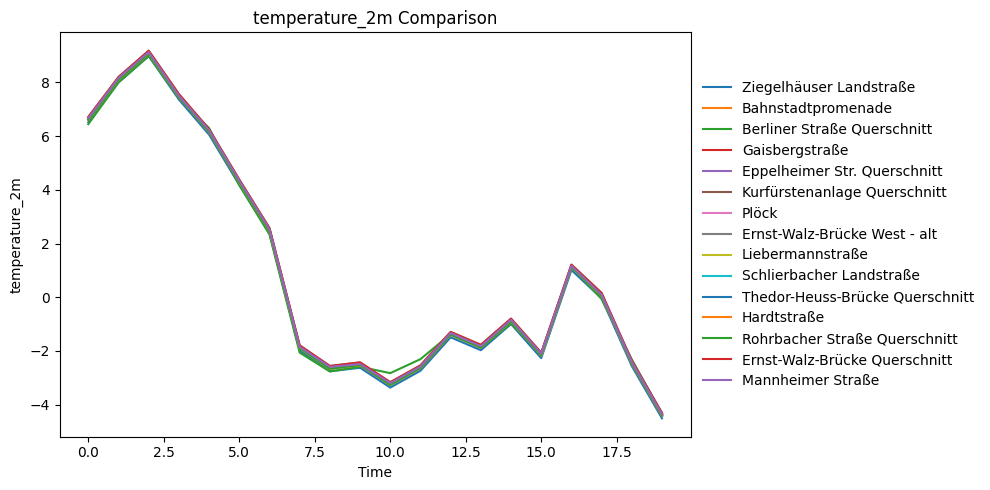

In [57]:
plot_column_from_dataframes(list(weather_data.values()), "temperature_2m", list(weather_data.keys()))

#### Result
We found that we cannot use the weather data to describe local weather events, since the data is the same for nearly all stations.

### Compare site_temperature (bicycle dataset) vs. temperature_2m (weather dataset)

Merge bicycle count data with weather data. Weather data is the same for all stations.

In [5]:
df_merged = dl.get_bicycle_with_weather("Ziegelhäuser Landstraße", interval=("2017-09-01", "2026-10-10"))

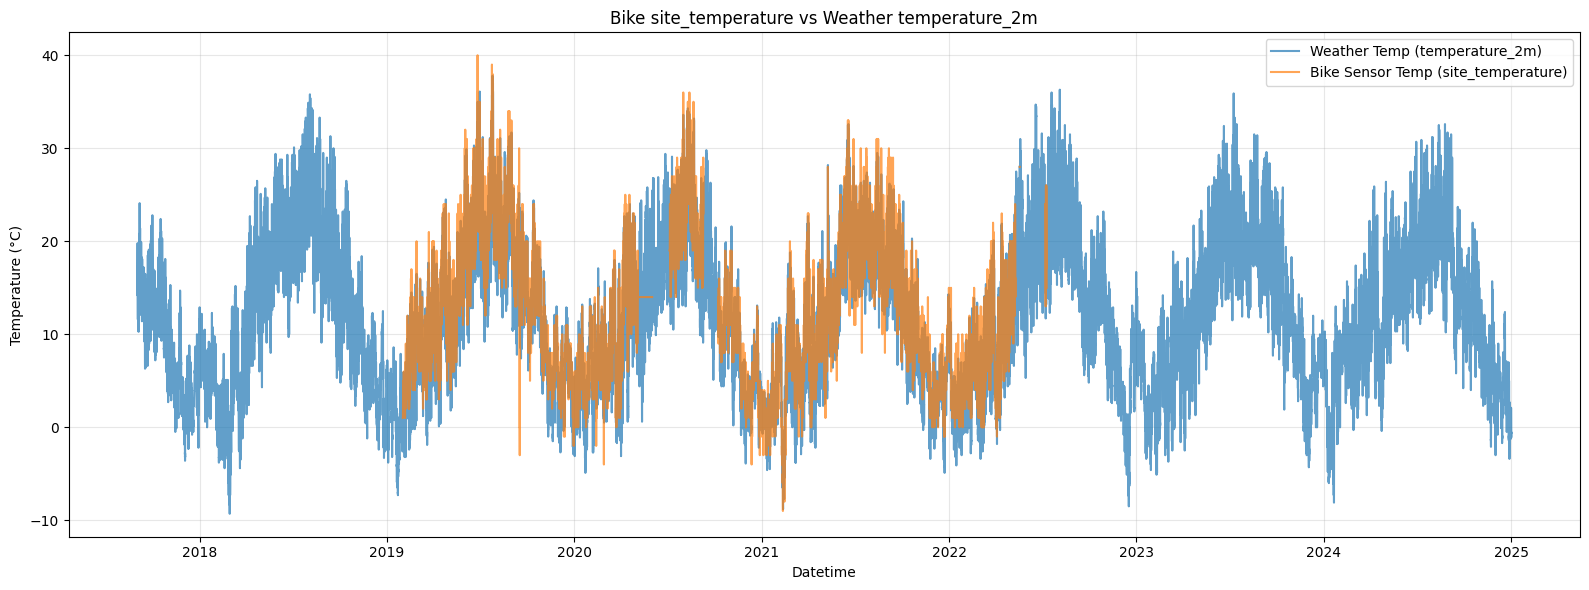

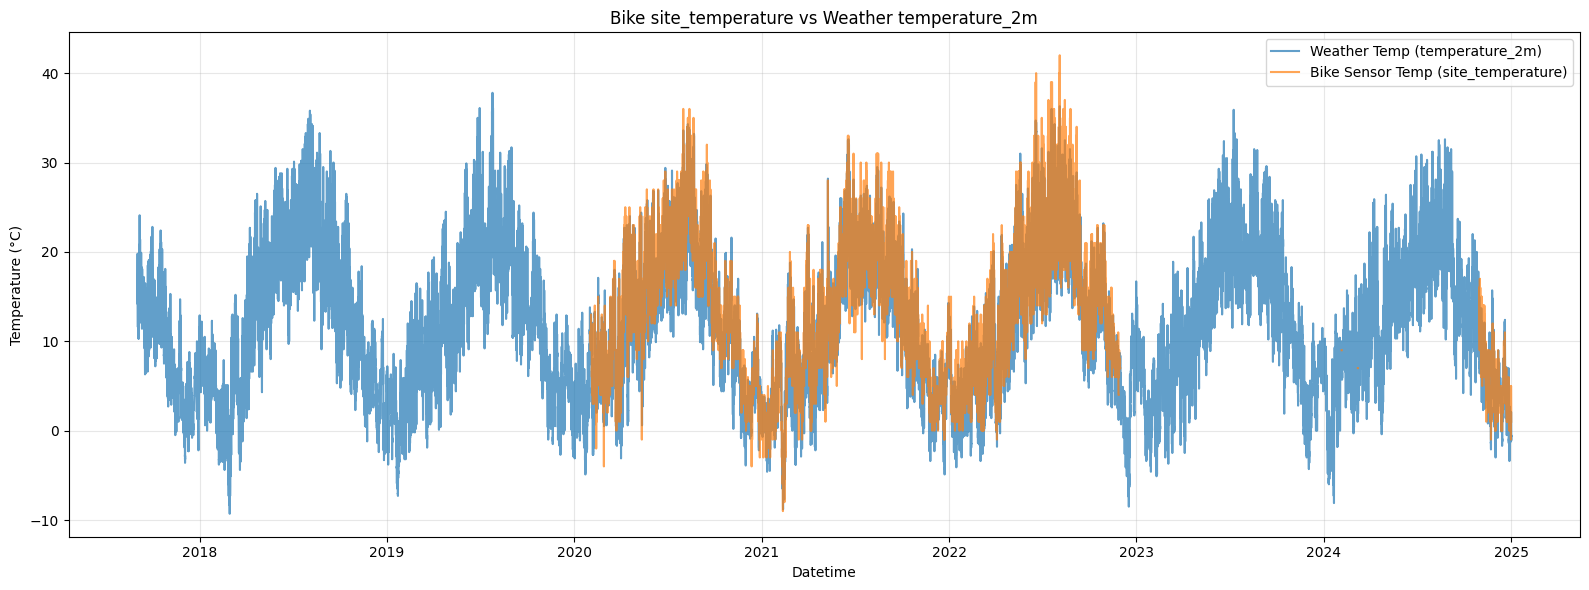

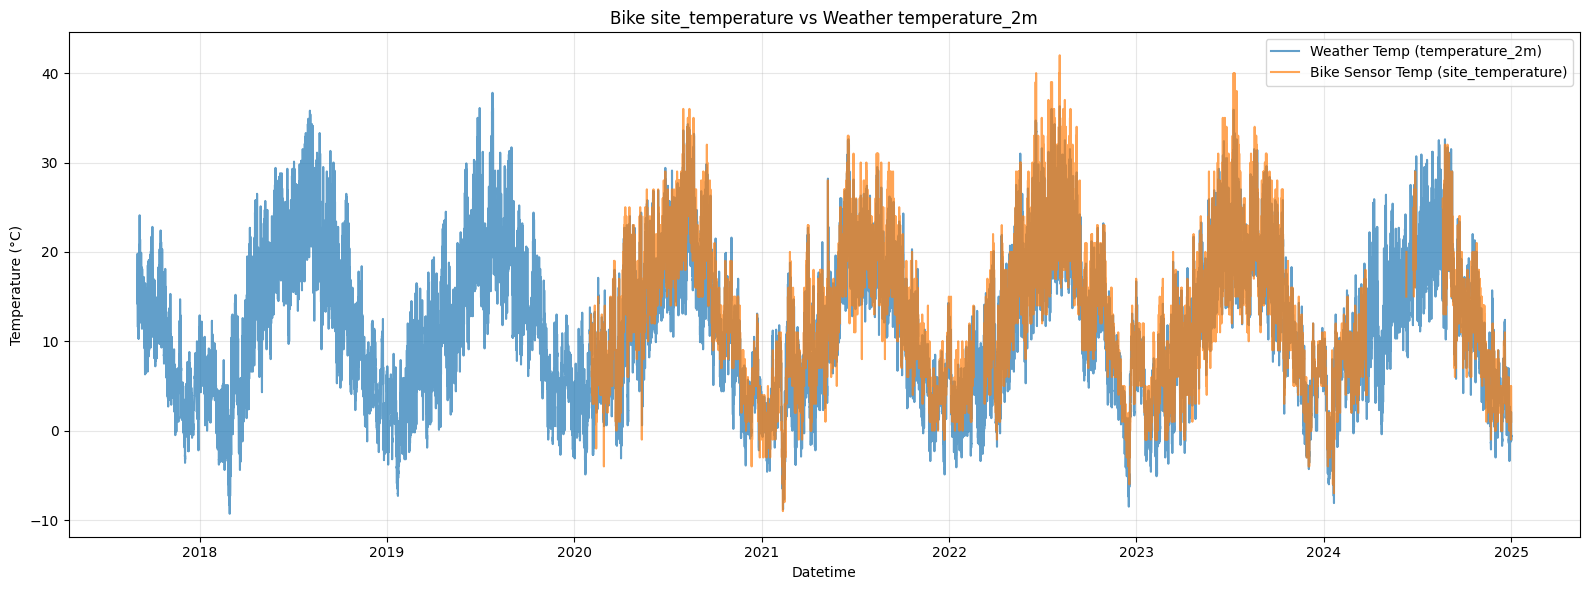

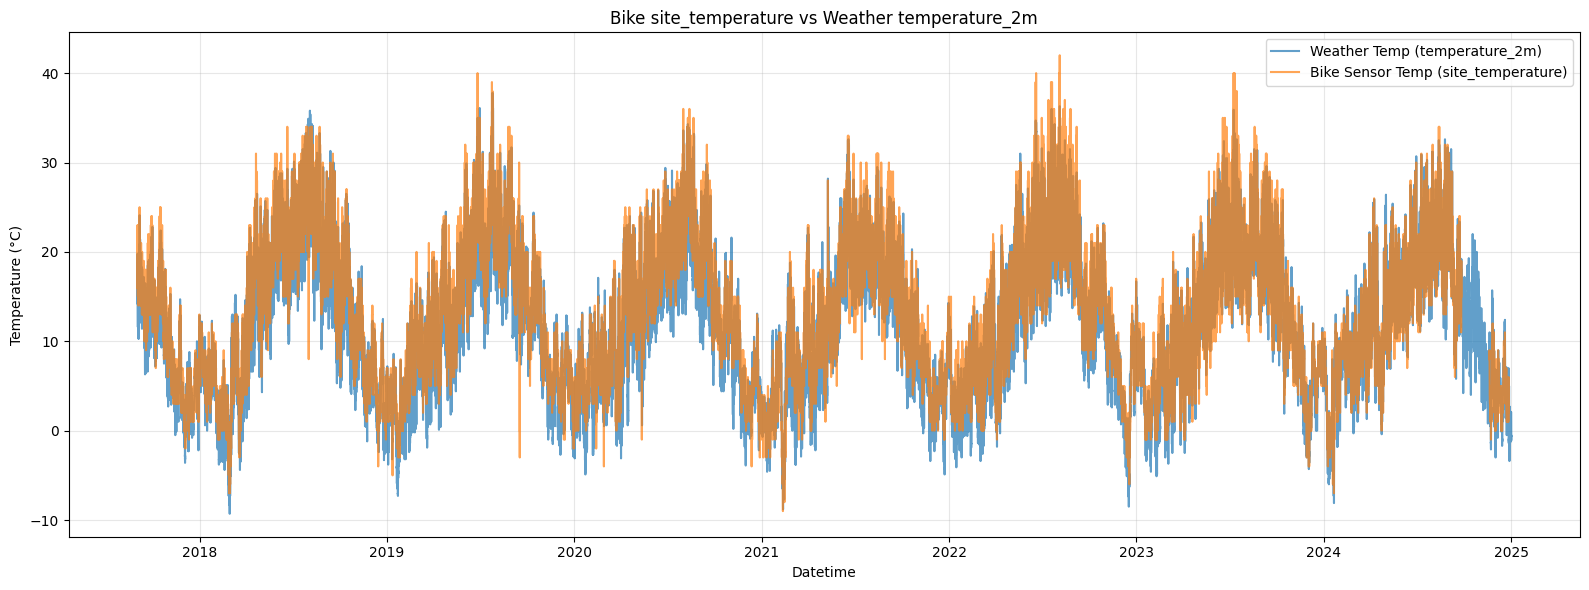

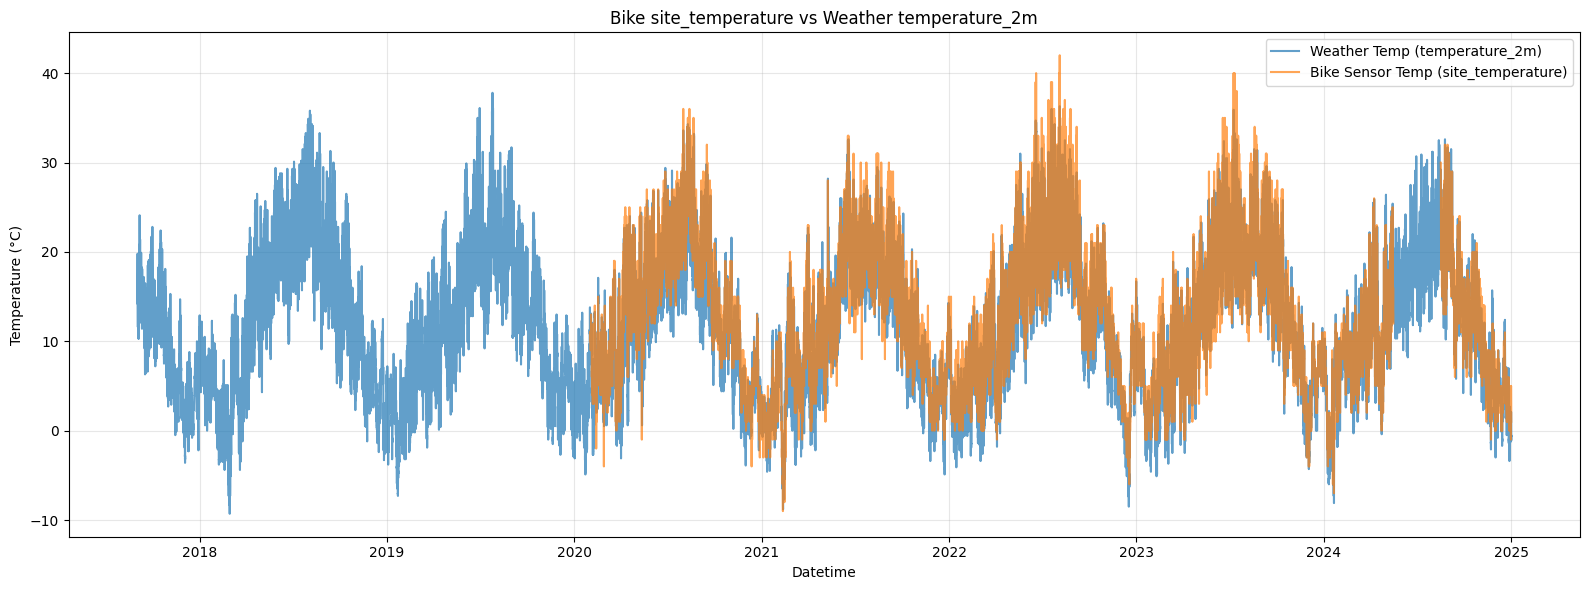

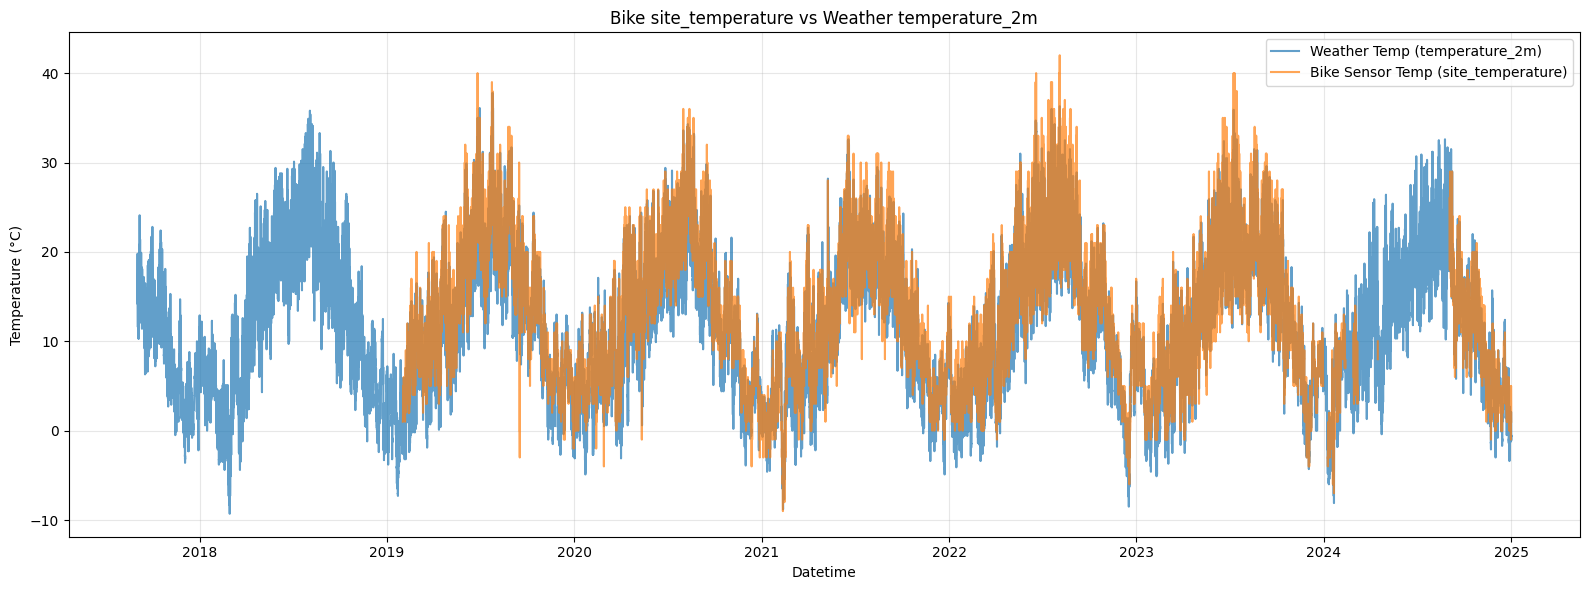

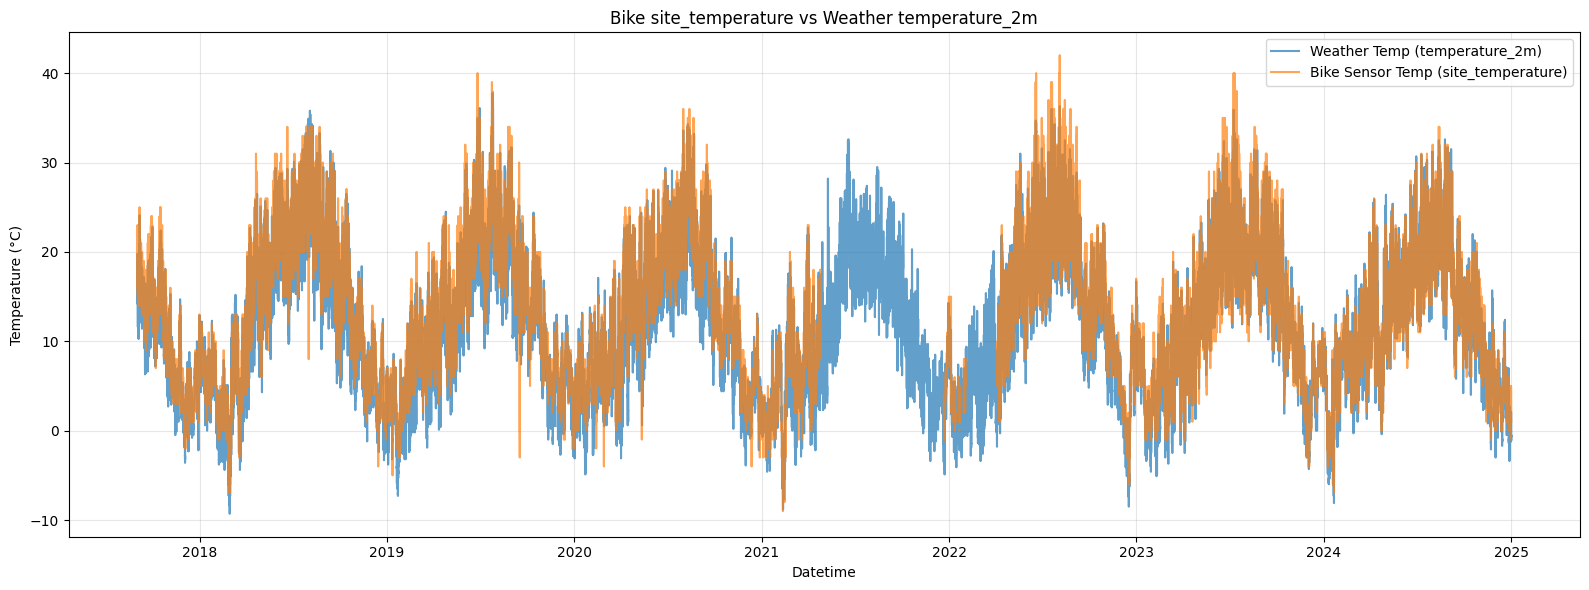

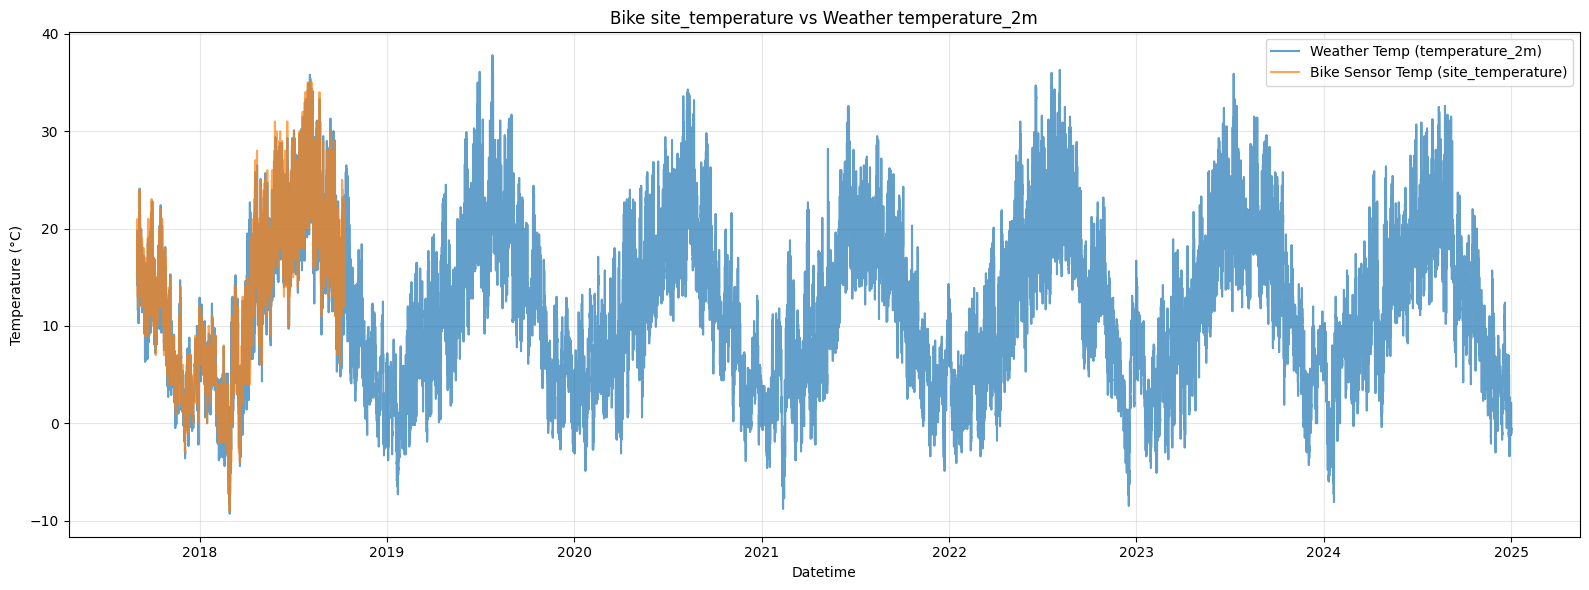

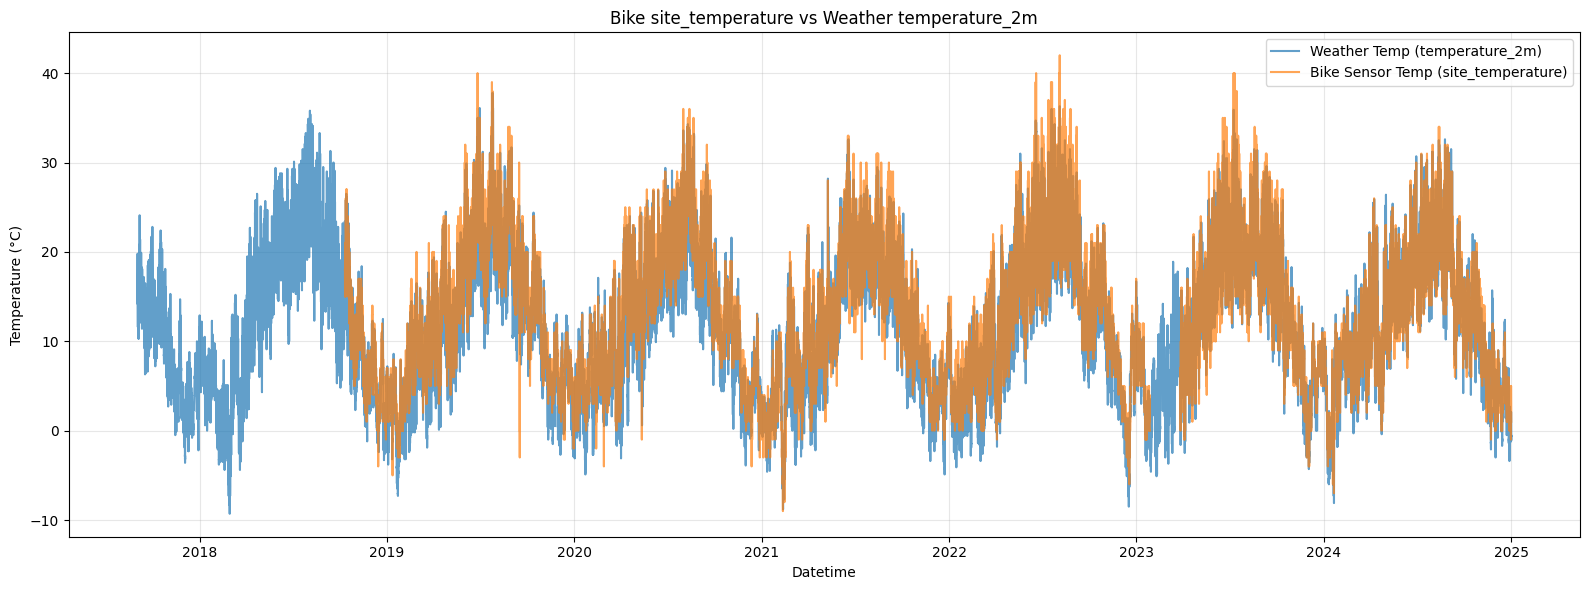

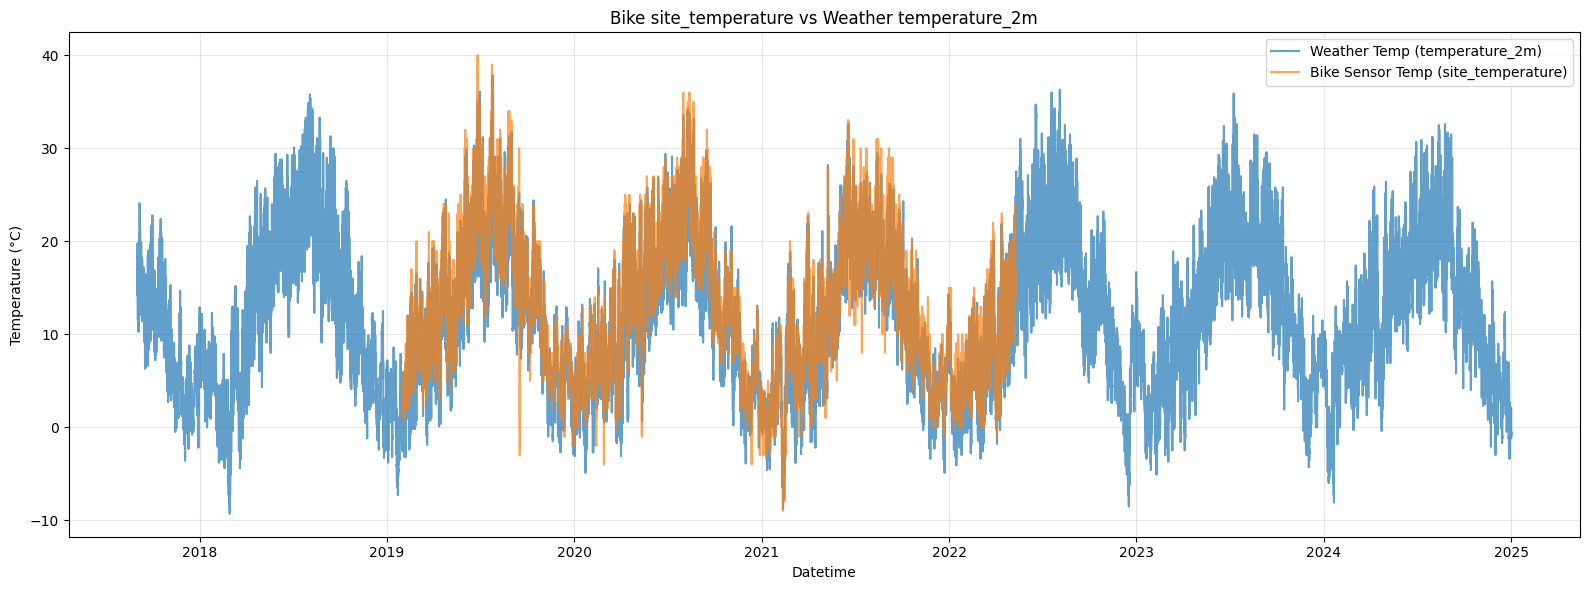

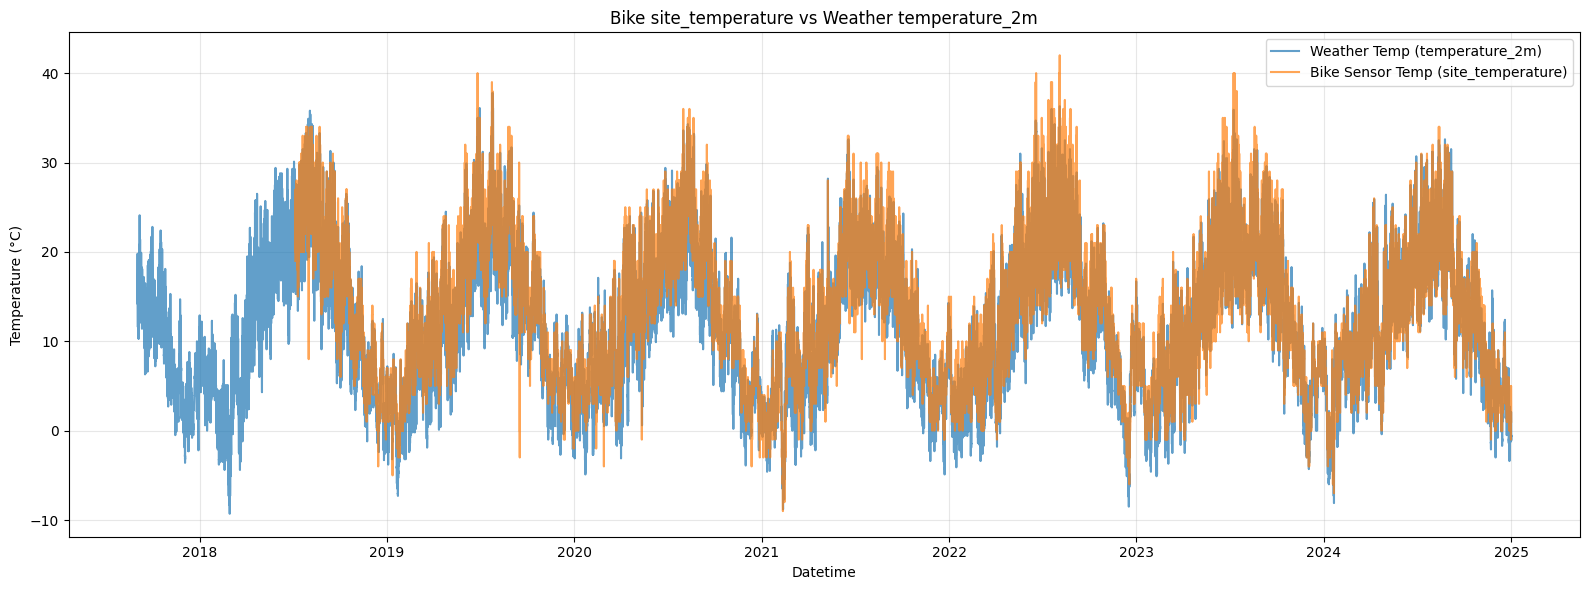

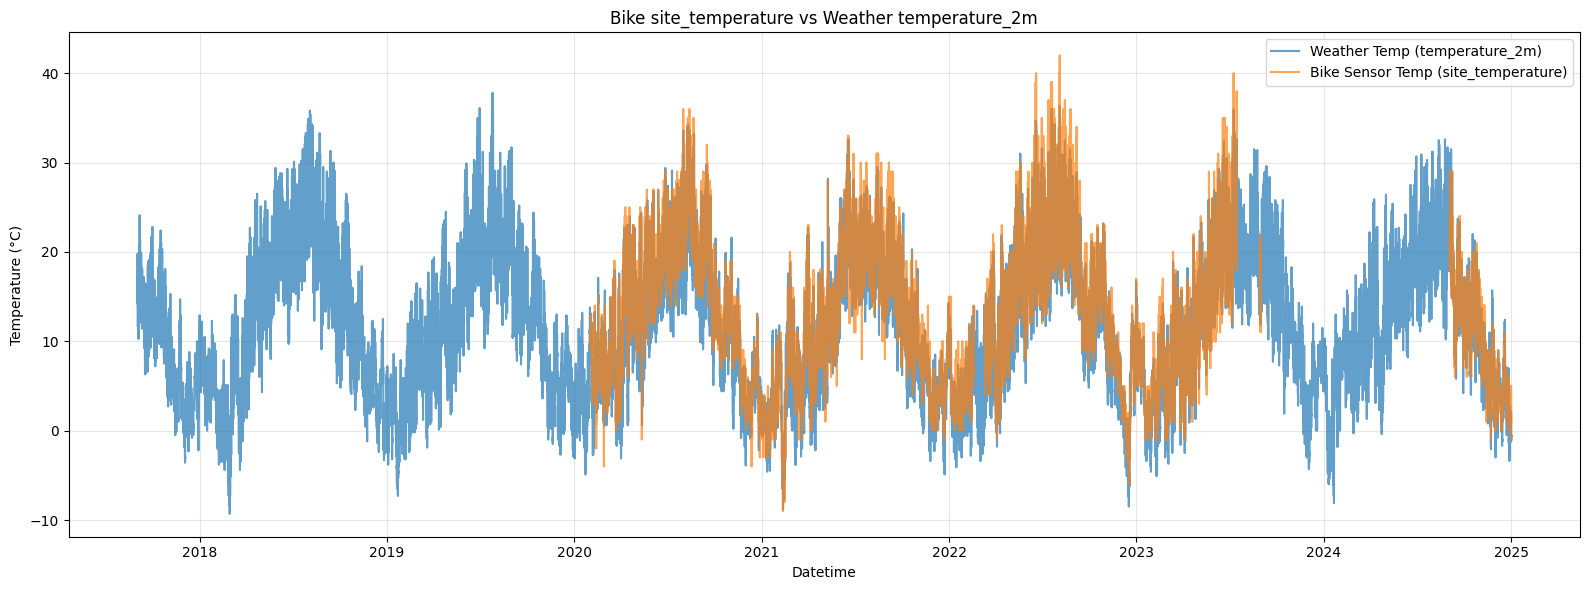

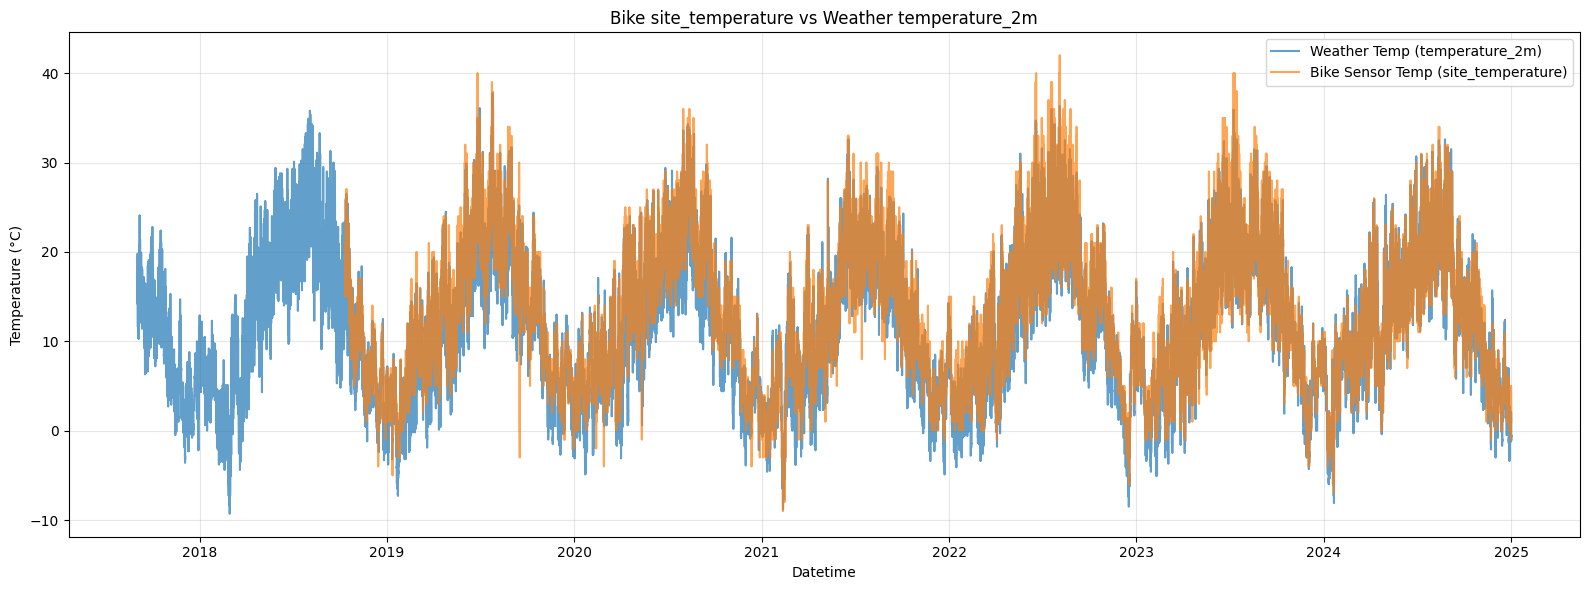

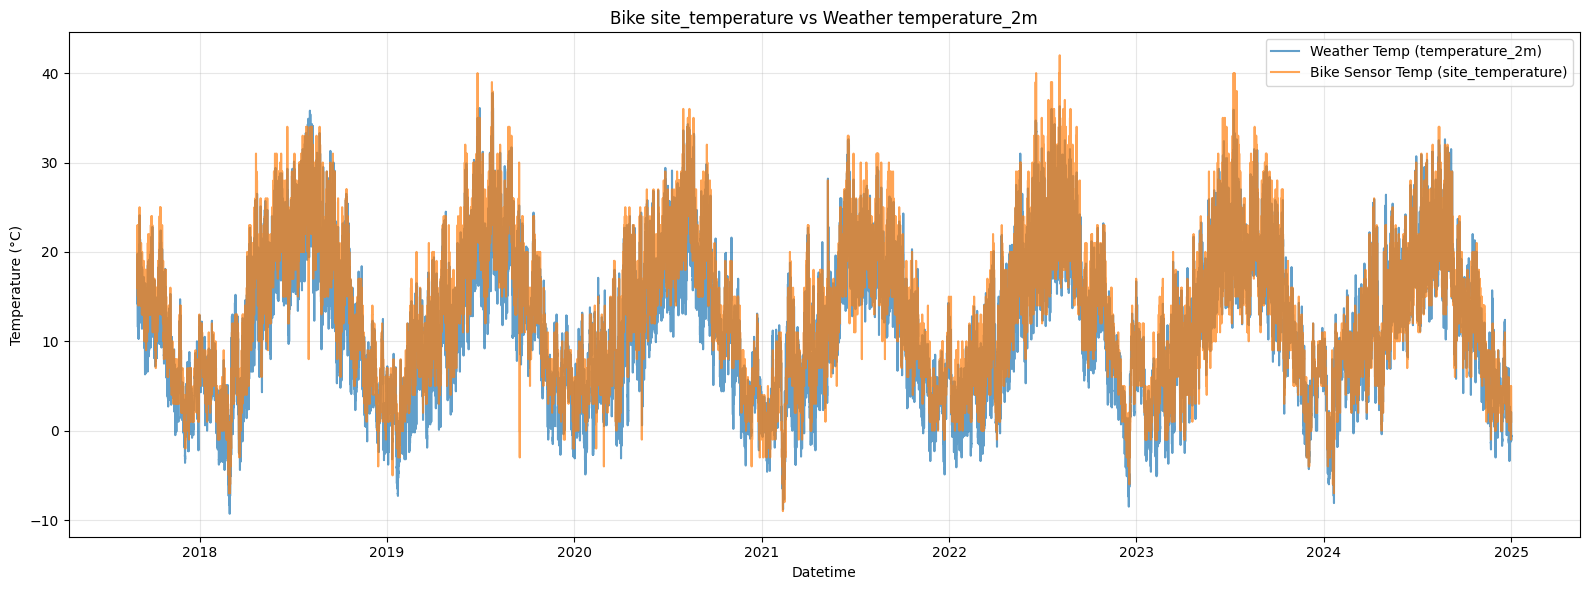

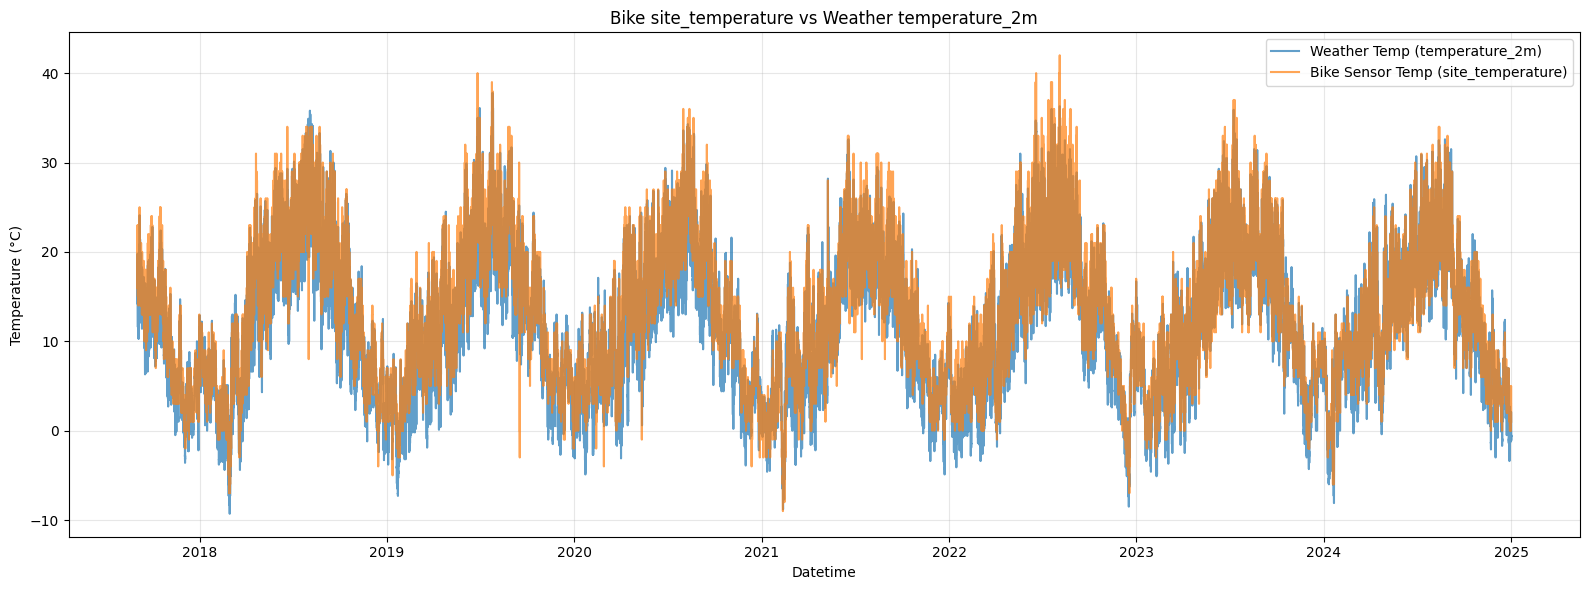

In [5]:
import matplotlib.pyplot as plt

def plot_temp_comparison(interval = ("2017-09-01", "2026-10-10")):
    for station in dl.get_bicyle_stations():
        df_merged = dl.get_bicycle_with_weather(station, interval=interval)

        plt.figure(figsize=(16,6))

        plt.plot(
            df_merged["datetime"],
            df_merged["temperature_2m"],
            label="Weather Temp (temperature_2m)",
            alpha=0.7
        )

        plt.plot(
            df_merged["datetime"],
            df_merged["site_temperature"],
            label="Bike Sensor Temp (site_temperature)",
            alpha=0.7
        )

        plt.title("Bike site_temperature vs Weather temperature_2m")
        plt.xlabel("Datetime")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

plot_temp_comparison()

In [6]:
import polars as pl

def get_temp_diff(station, interval=("2017-09-01", "2026-10-10")):
    df = dl.get_bicycle_with_weather(station, interval=interval)

    # Differenz-Spalte hinzufügen
    df = df.with_columns(
        (pl.col("site_temperature") - pl.col("temperature_2m"))
        .alias("temp_diff")
    )
    return df


<Figure size 1400x600 with 0 Axes>

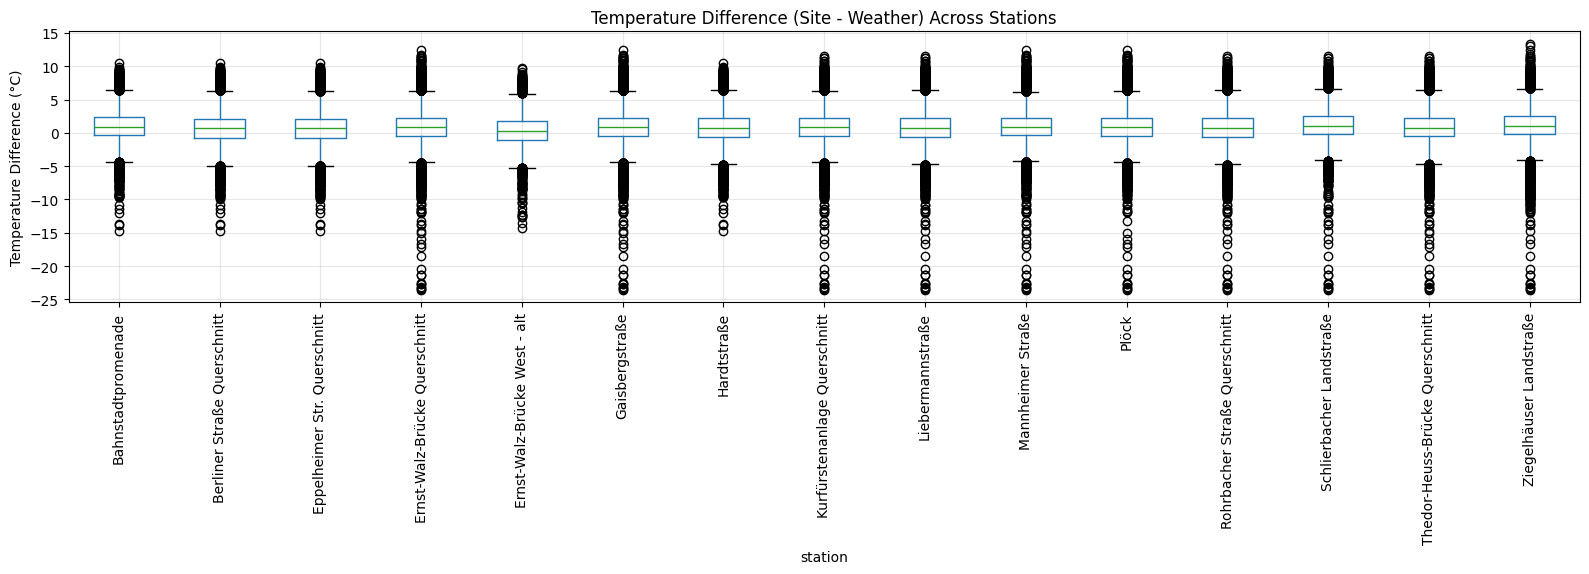

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def boxplot_temp_diff(interval=("2017-09-01", "2026-10-10")):
    rows = []
    for station in dl.get_bicyle_stations():
        df = get_temp_diff(station, interval)
        rows.append(
            pd.DataFrame({
                "station": station,
                "temp_diff": df["temp_diff"].to_list()
            })
        )

    df_all = pd.concat(rows)

    plt.figure(figsize=(14,6))
    df_all.boxplot(by="station", column="temp_diff", rot=90, figsize=(16,6))
    plt.suptitle("")
    plt.title("Temperature Difference (Site - Weather) Across Stations")
    plt.ylabel("Temperature Difference (°C)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
boxplot_temp_diff()

In [8]:
def summary_stats(interval=("2017-09-01", "2026-10-10")):
    stats = []

    for station in dl.get_bicyle_stations():
        df = get_temp_diff(station, interval)

        stats.append({
            "station": station,
            "mean_diff": float(df["temp_diff"].mean()),
            "median_diff": float(df["temp_diff"].median()),
            "std_diff": float(df["temp_diff"].std()),
            "min_diff": float(df["temp_diff"].min()),
            "max_diff": float(df["temp_diff"].max()),
        })

    return pl.DataFrame(stats)

stats_df = summary_stats()
stats_df


shape: (15, 6)
┌─────────────────────────────────┬───────────┬─────────────┬──────────┬──────────┬──────────┐
│ station                         ┆ mean_diff ┆ median_diff ┆ std_diff ┆ min_diff ┆ max_diff │
│ ---                             ┆ ---       ┆ ---         ┆ ---      ┆ ---      ┆ ---      │
│ str                             ┆ f64       ┆ f64         ┆ f64      ┆ f64      ┆ f64      │
╞═════════════════════════════════╪═══════════╪═════════════╪══════════╪══════════╪══════════╡
│ Ziegelhäuser Landstraße         ┆ 1.223495  ┆ 1.1         ┆ 2.379814 ┆ -23.6    ┆ 13.4     │
│ Bahnstadtpromenade              ┆ 1.077617  ┆ 0.9         ┆ 2.255409 ┆ -14.8    ┆ 10.5     │
│ Berliner Straße Querschnitt     ┆ 0.756926  ┆ 0.7         ┆ 2.33144  ┆ -14.8    ┆ 10.5     │
│ Gaisbergstraße                  ┆ 0.954838  ┆ 0.9         ┆ 2.336907 ┆ -23.6    ┆ 12.4     │
│ Eppelheimer Str. Querschnitt    ┆ 0.728942  ┆ 0.7         ┆ 2.334138 ┆ -14.8    ┆ 10.5     │
│ …                               ┆ …         ┆ …           ┆ …        ┆ …        ┆ …        │
│ Thedor-Heuss-Brücke Querschnit… ┆ 0.876533  ┆ 0.8         ┆ 2.378179 ┆ -23.6    ┆ 11.5     │
│ Hardtstraße                     ┆ 0.847625  ┆ 0.8         ┆ 2.353229 ┆ -14.8    ┆ 10.5     │
│ Rohrbacher Straße Querschnitt   ┆ 0.850924  ┆ 0.8         ┆ 2.363189 ┆ -23.6    ┆ 11.5     │
│ Ernst-Walz-Brücke Querschnitt   ┆ 0.943634  ┆ 0.9         ┆ 2.33168  ┆ -23.6    ┆ 12.4     │
│ Mannheimer Straße               ┆ 1.039853  ┆ 0.9         ┆ 2.197324 ┆ -23.6    ┆ 12.4     │
└─────────────────────────────────┴───────────┴─────────────┴──────────┴──────────┴──────────┘

### Compare percipation between datasets

In [9]:
import polars as pl

def get_precip_diff(station, interval=("2017-09-01", "2026-10-10")):
    df = dl.get_bicycle_with_weather(station, interval=interval)

    df = df.with_columns([
        (pl.col("site_rain_accumulation") - pl.col("rain")).alias("rain_diff"),
        (pl.col("site_snow_accumulation") - pl.col("snowfall")).alias("snow_diff")
    ])

    return df

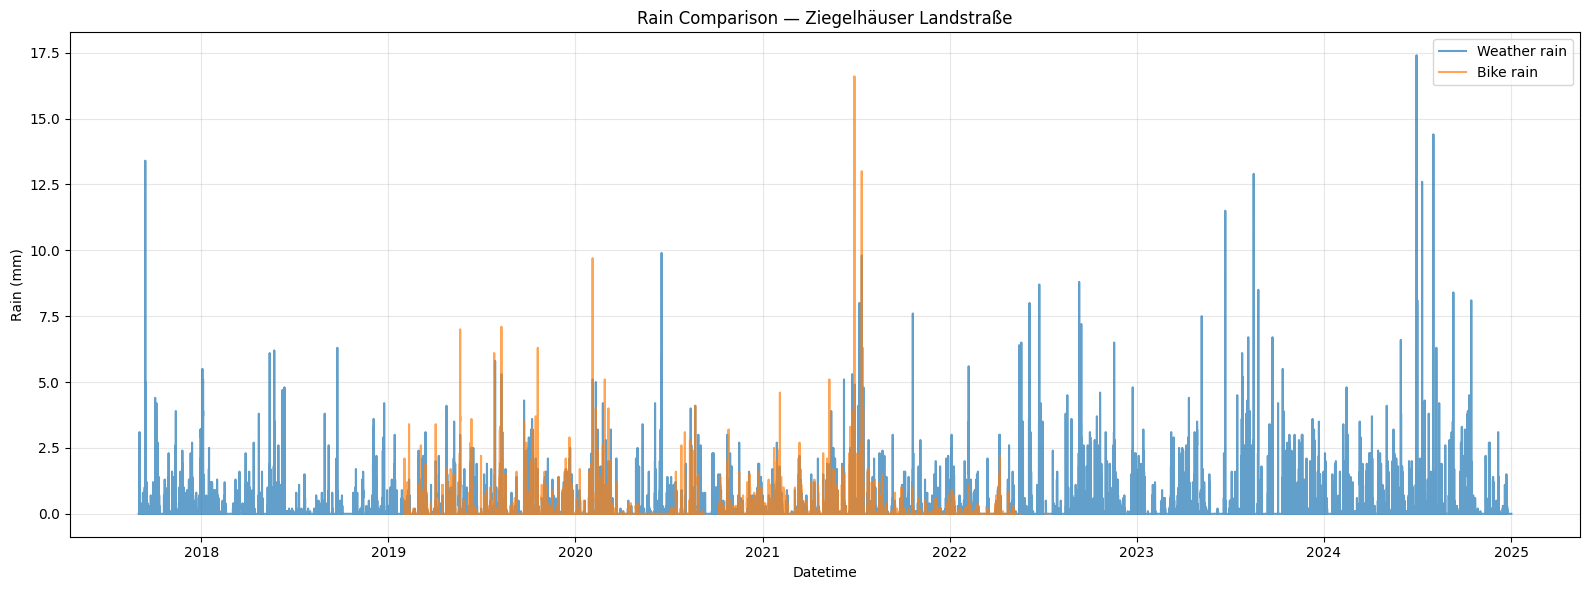

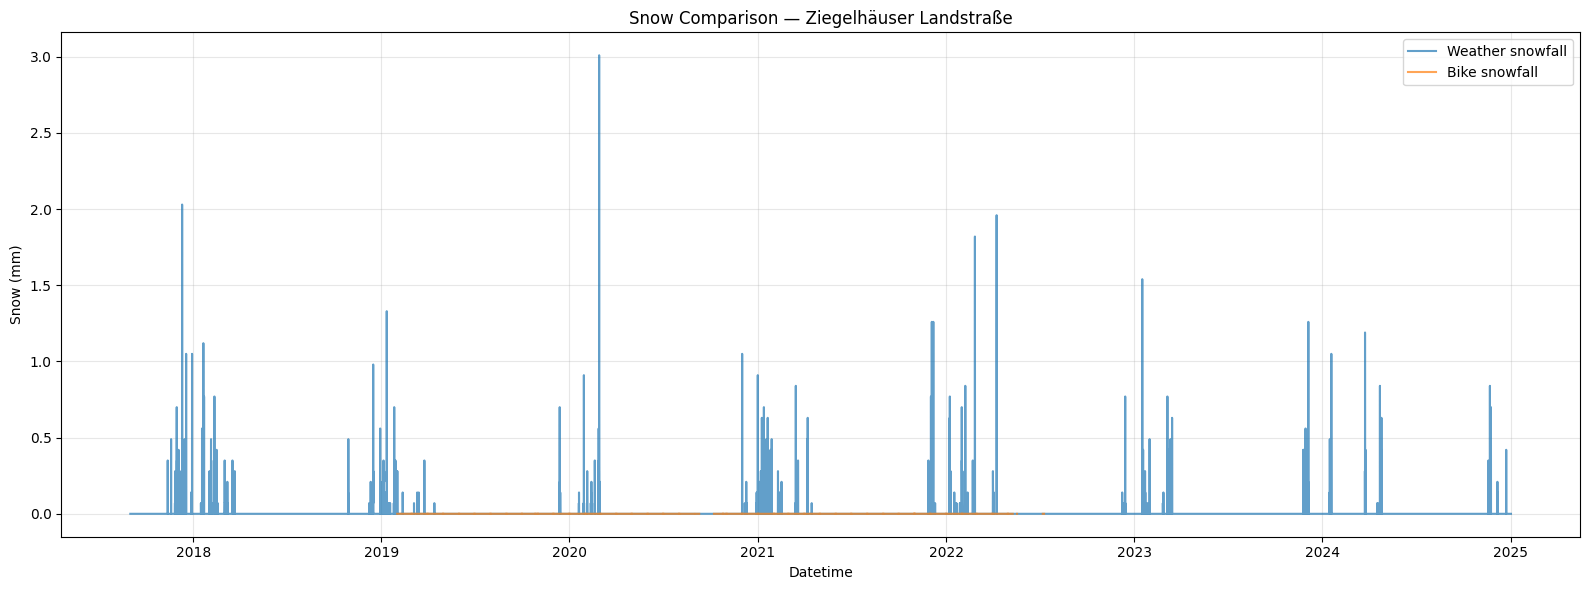

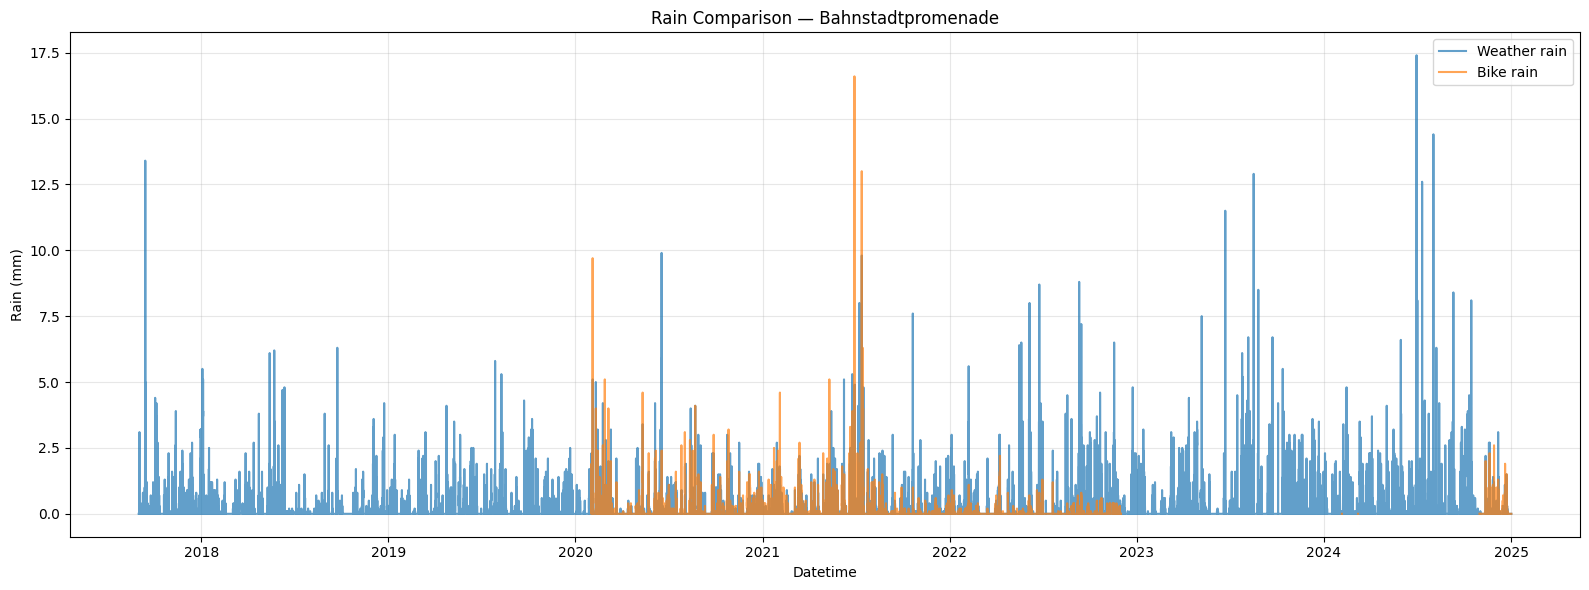

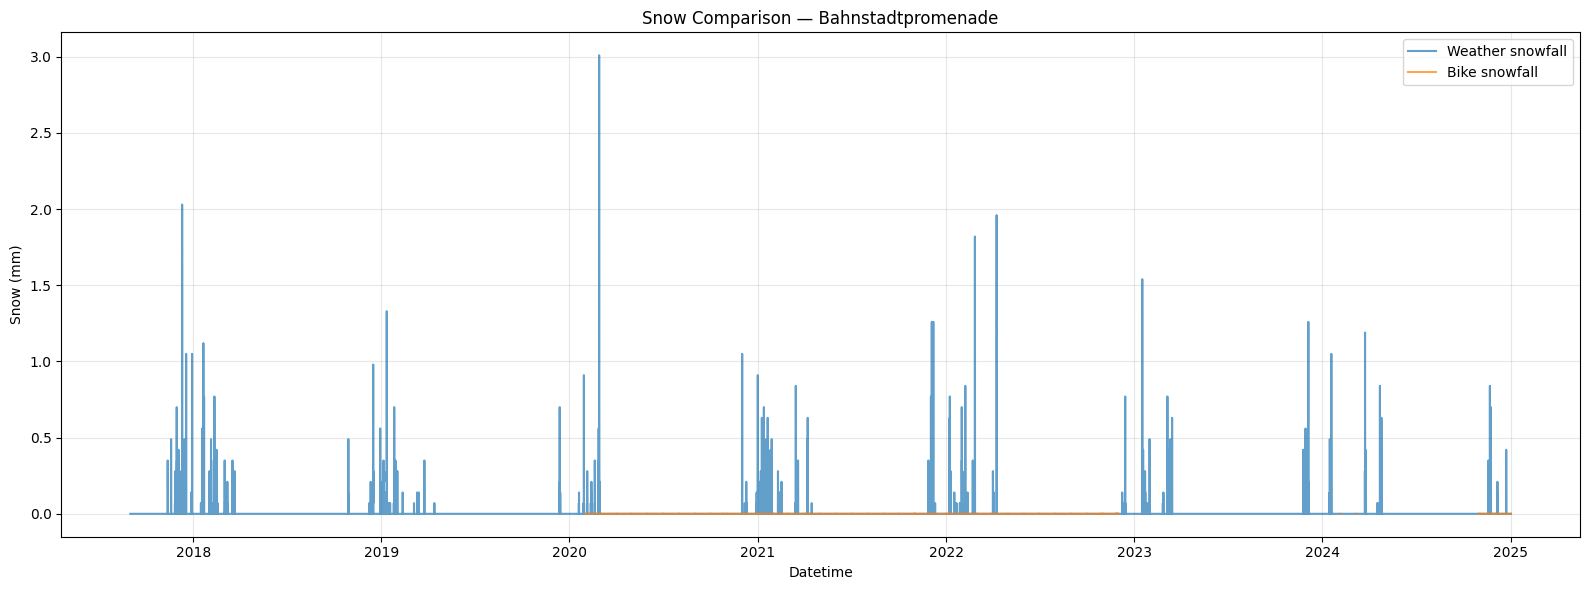

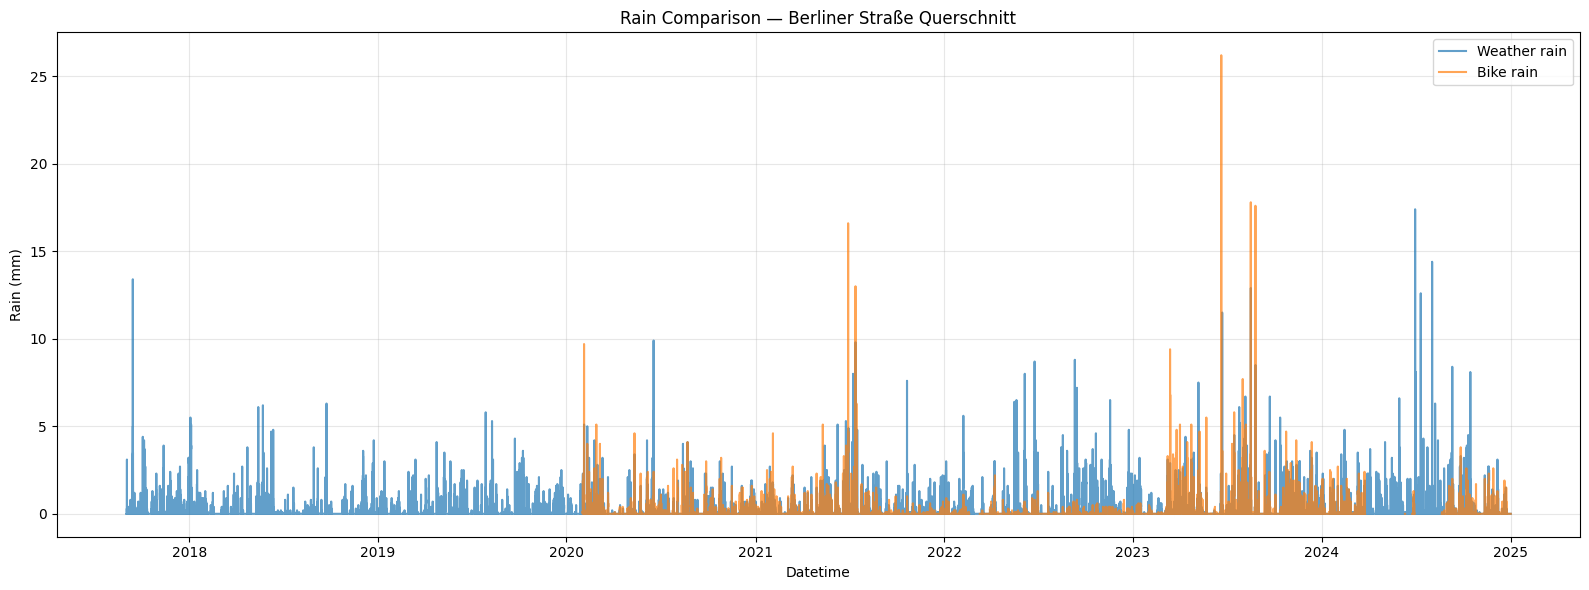

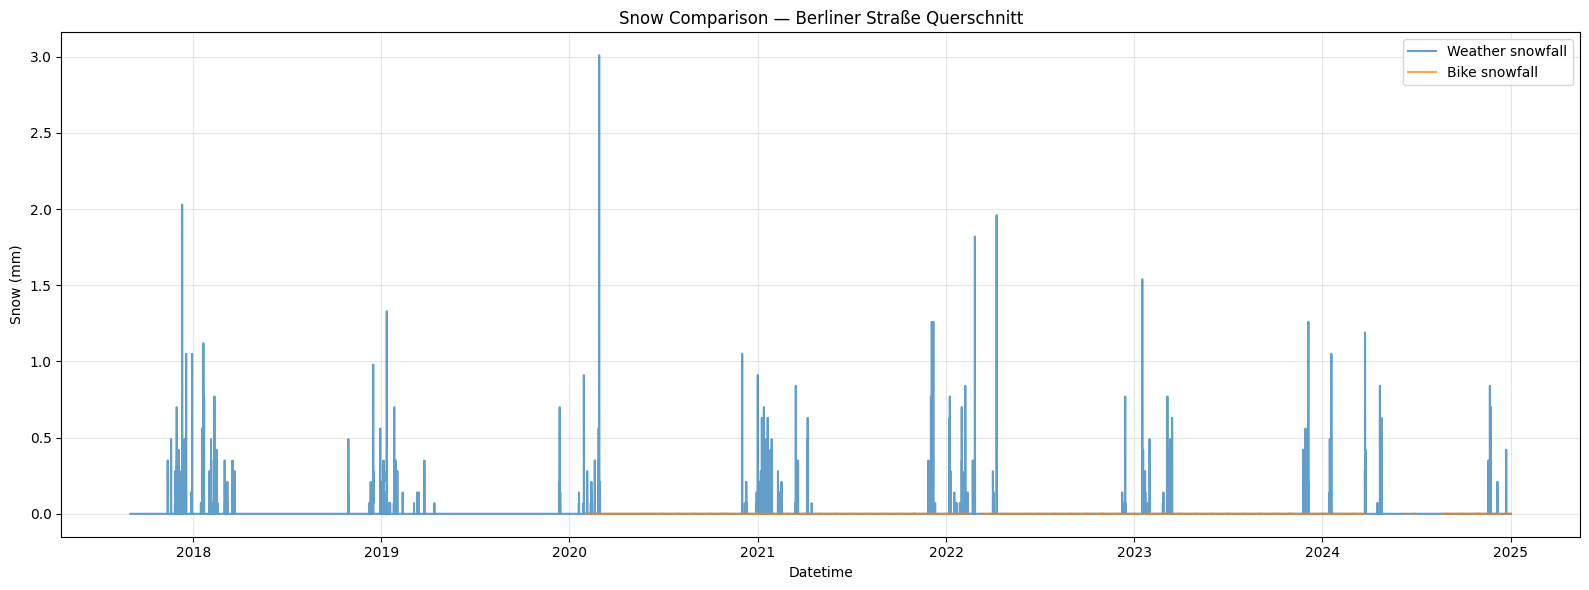

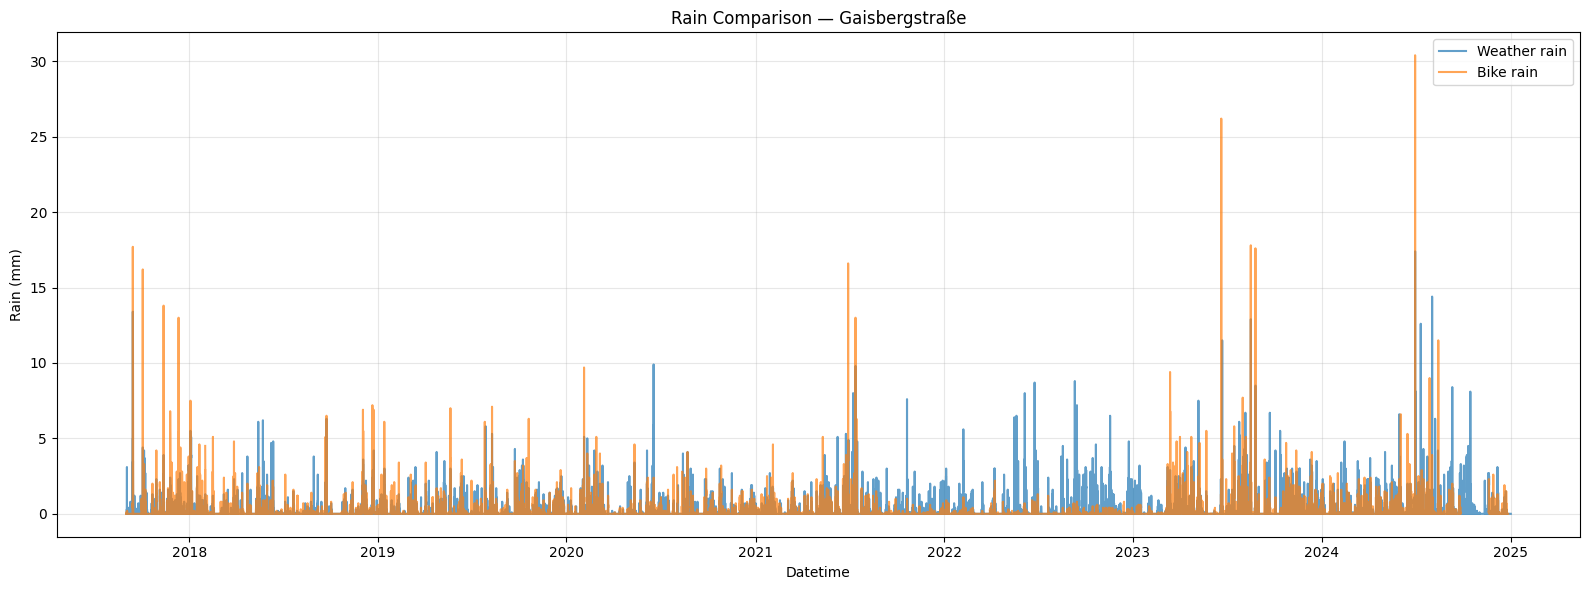

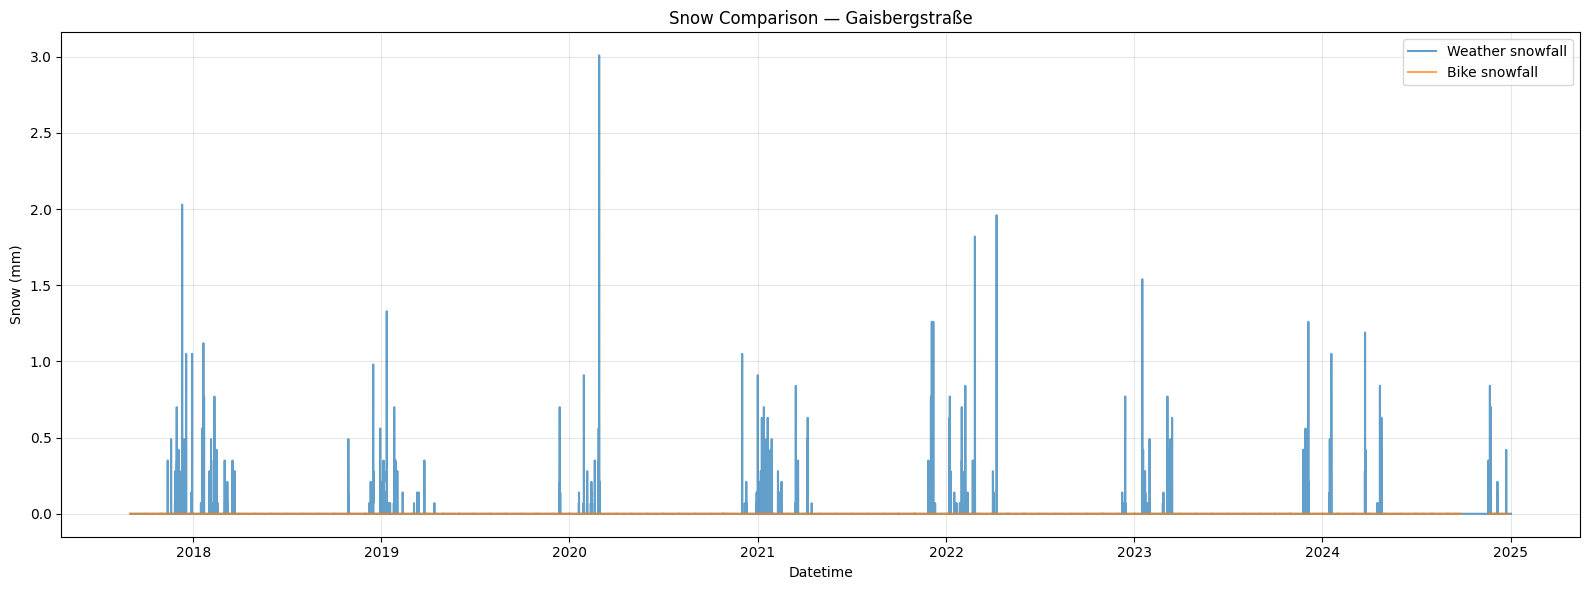

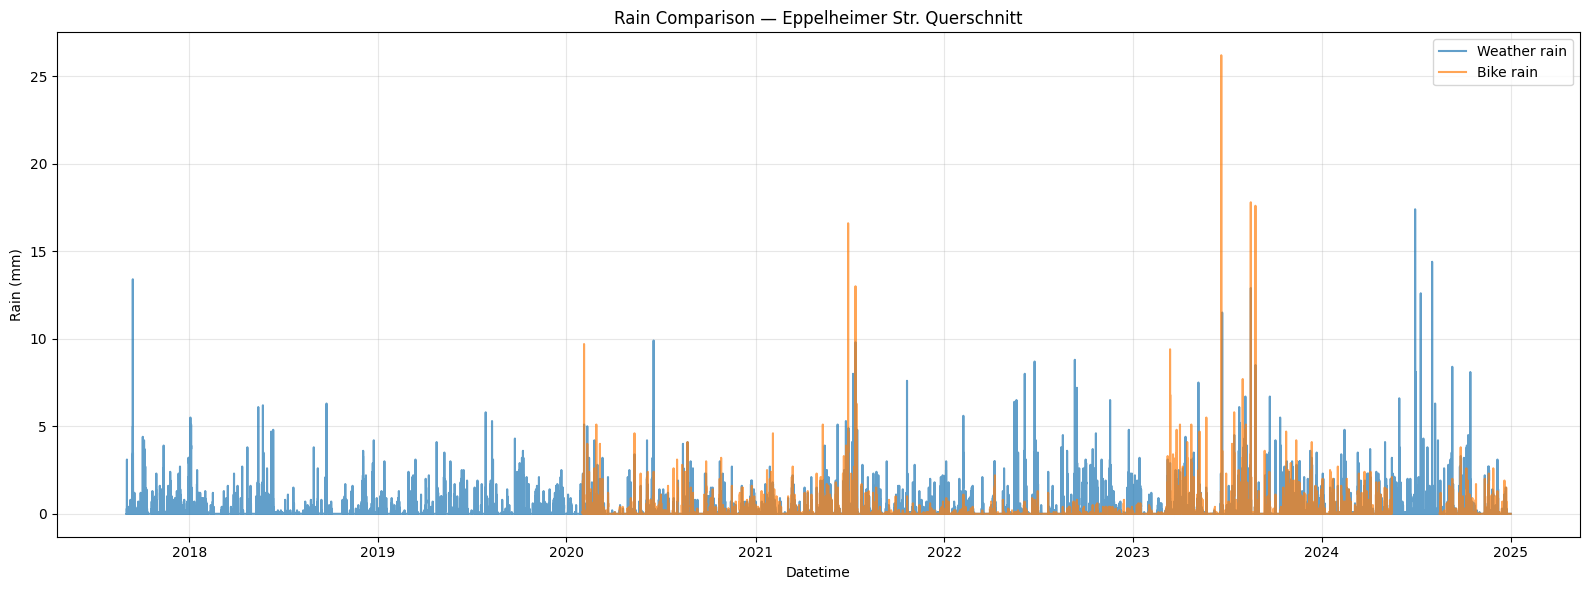

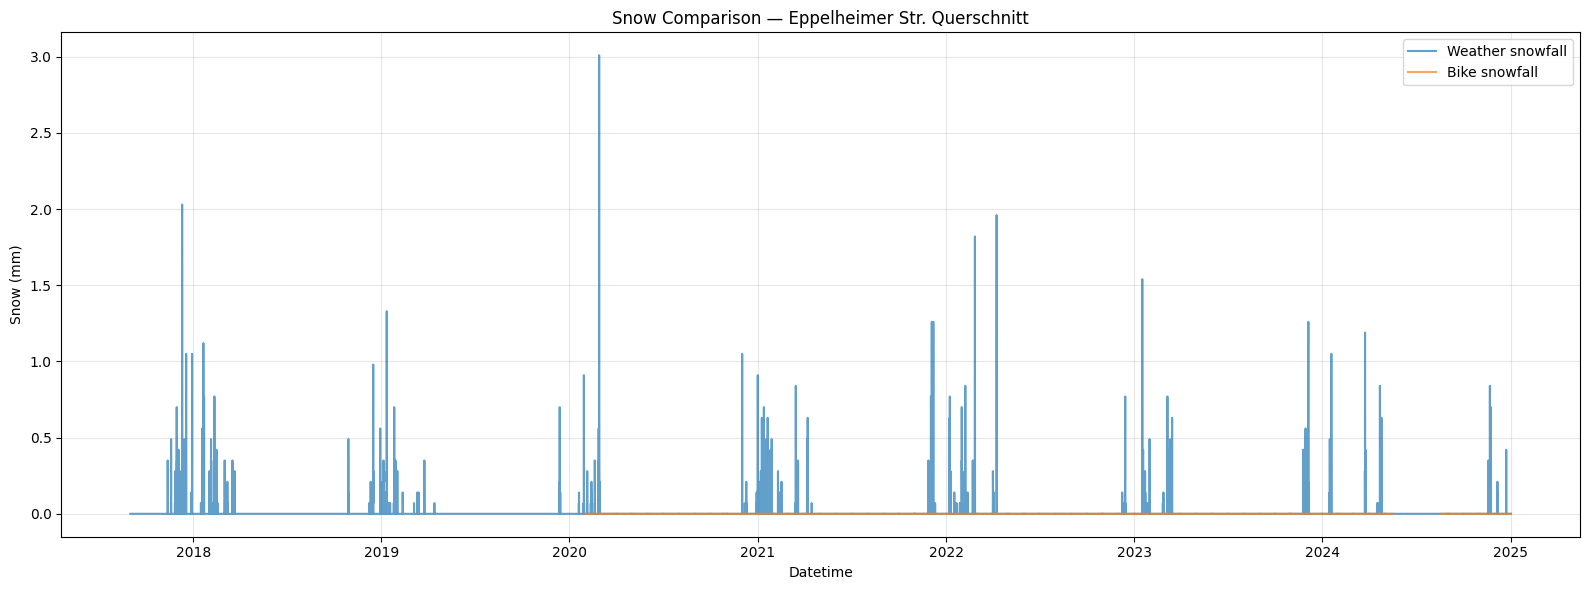

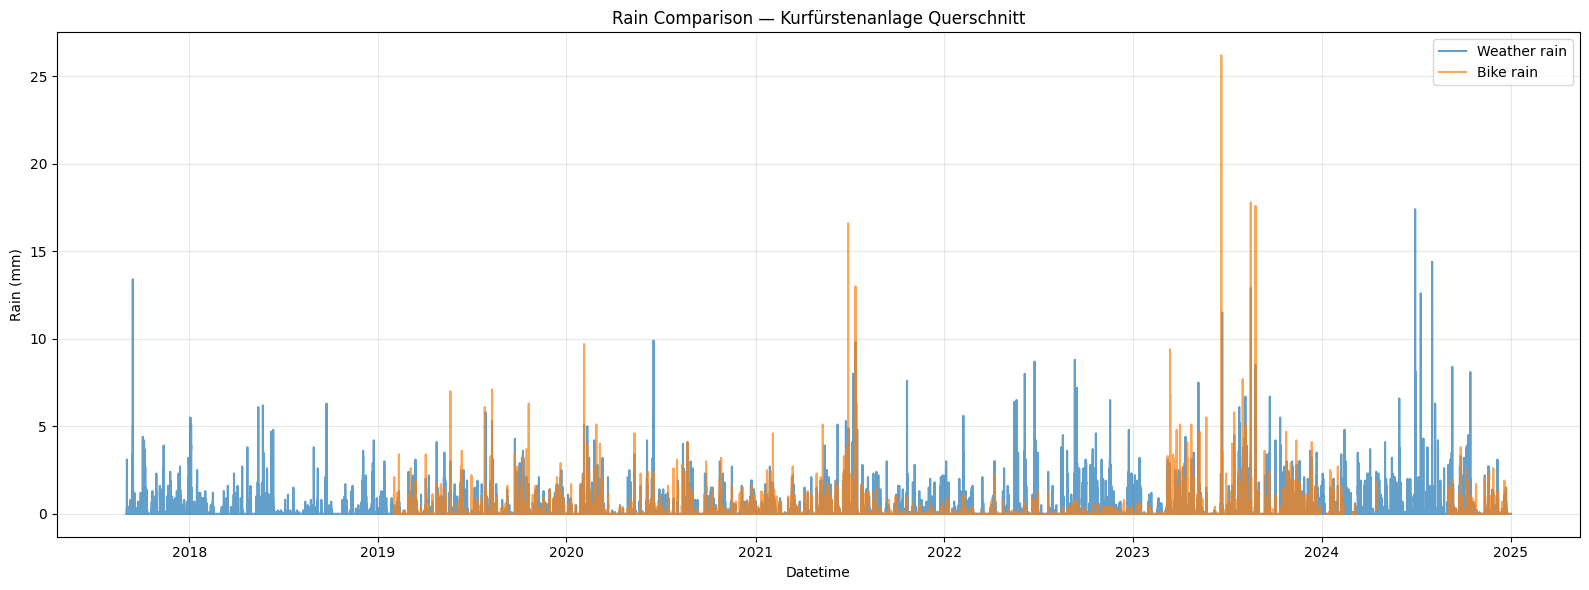

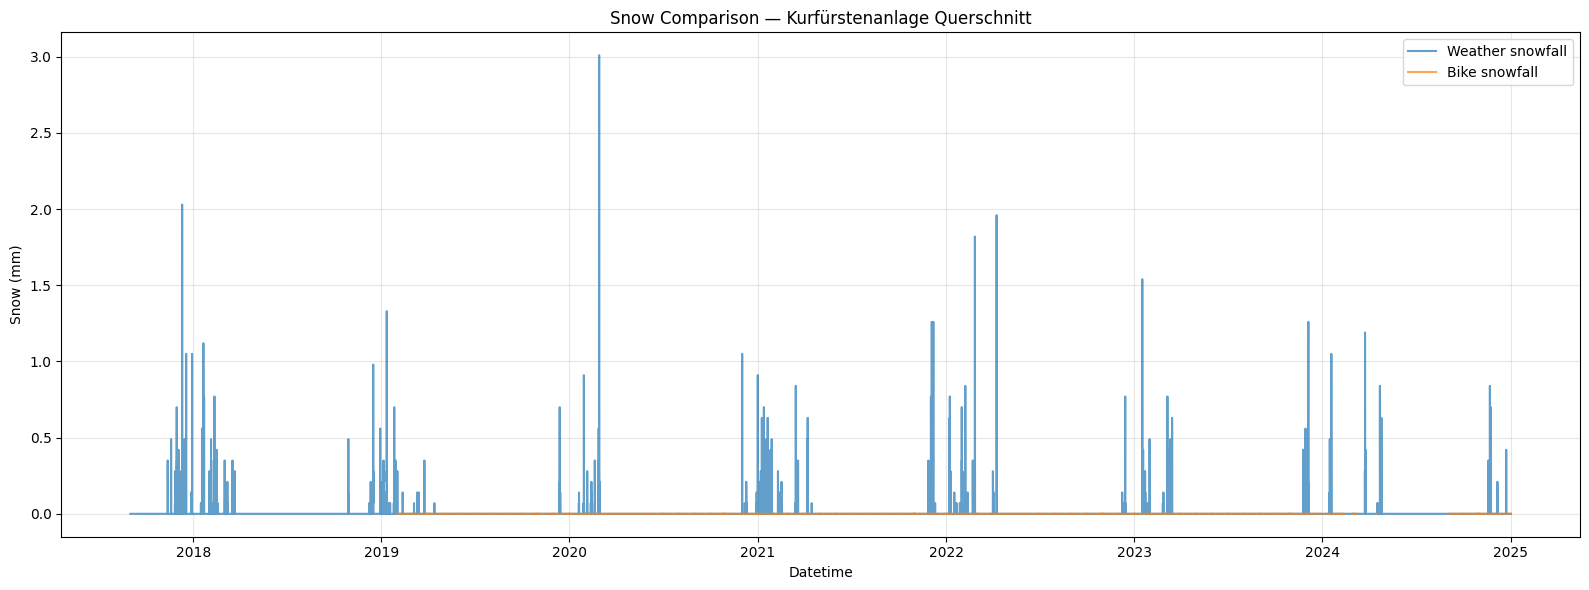

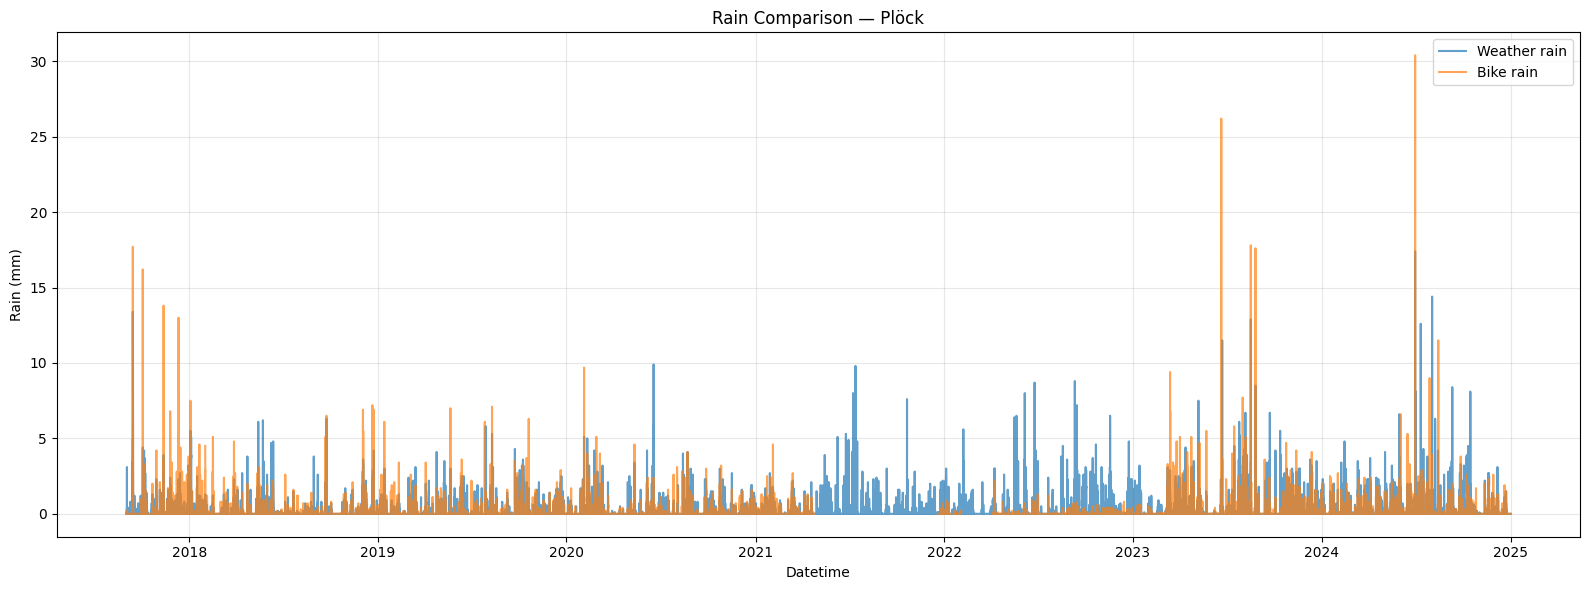

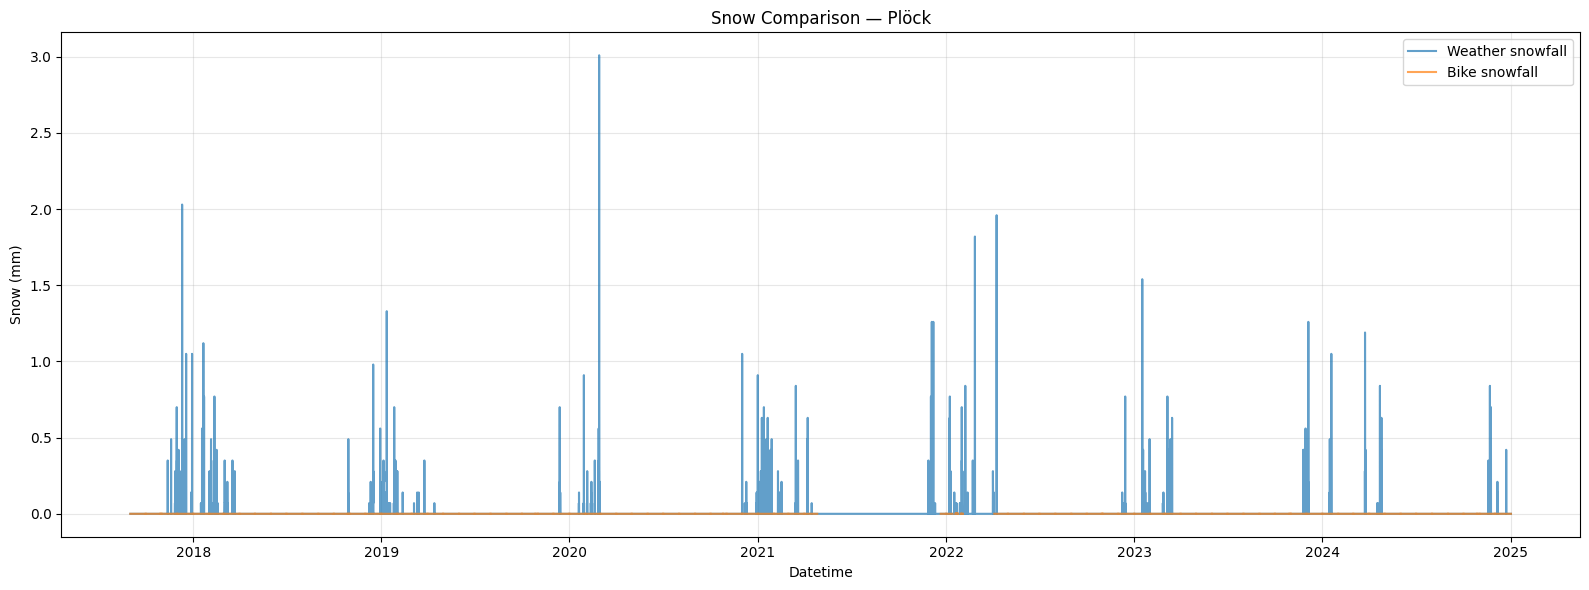

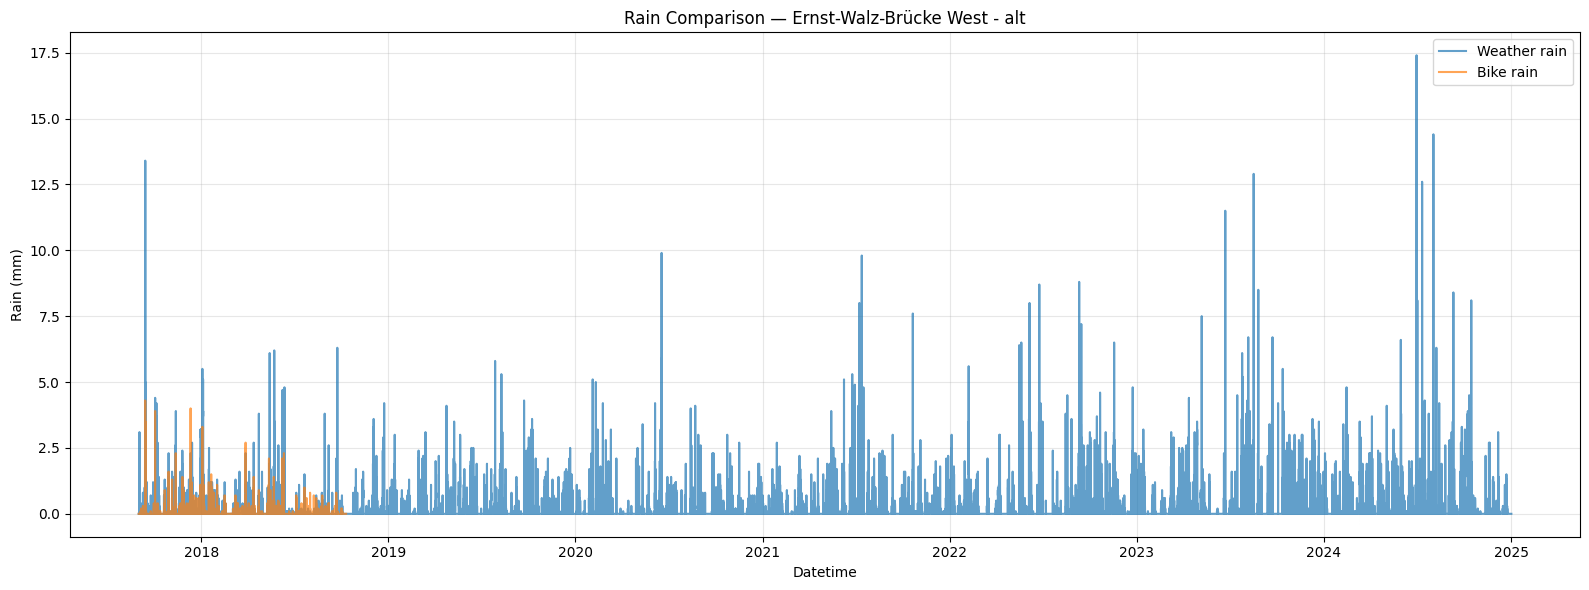

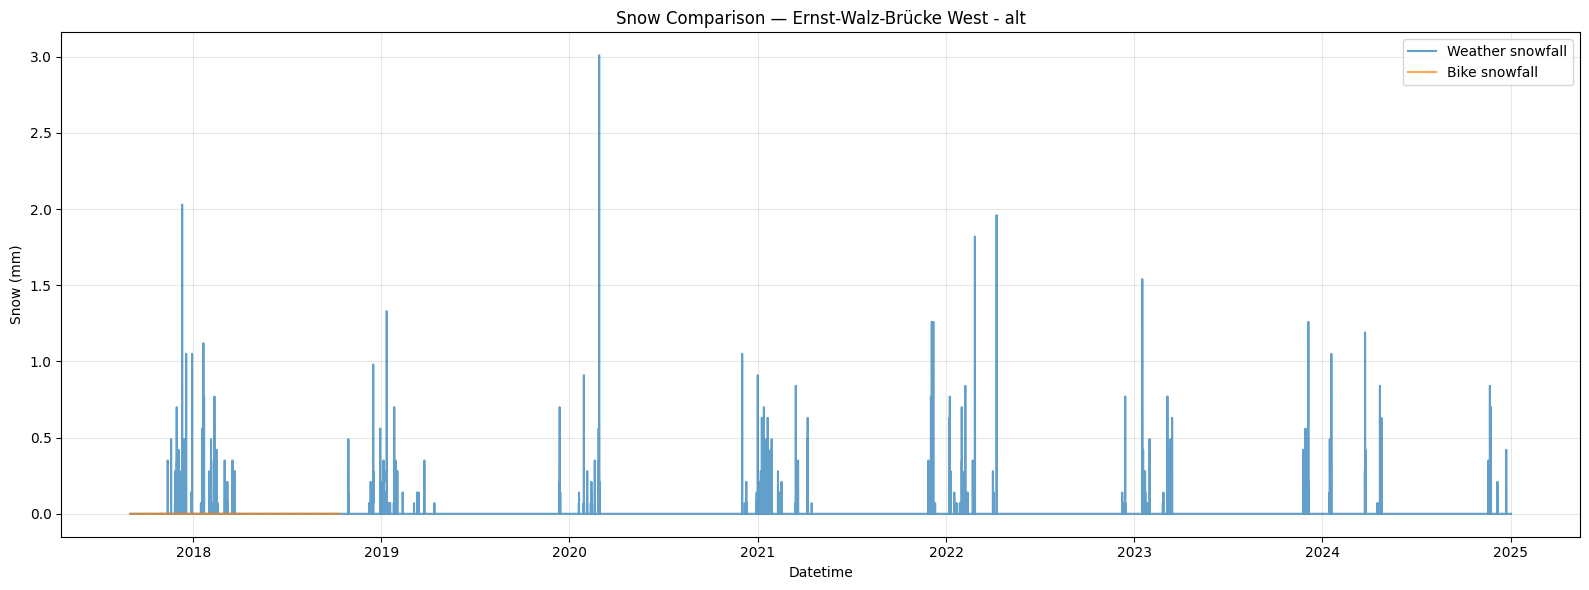

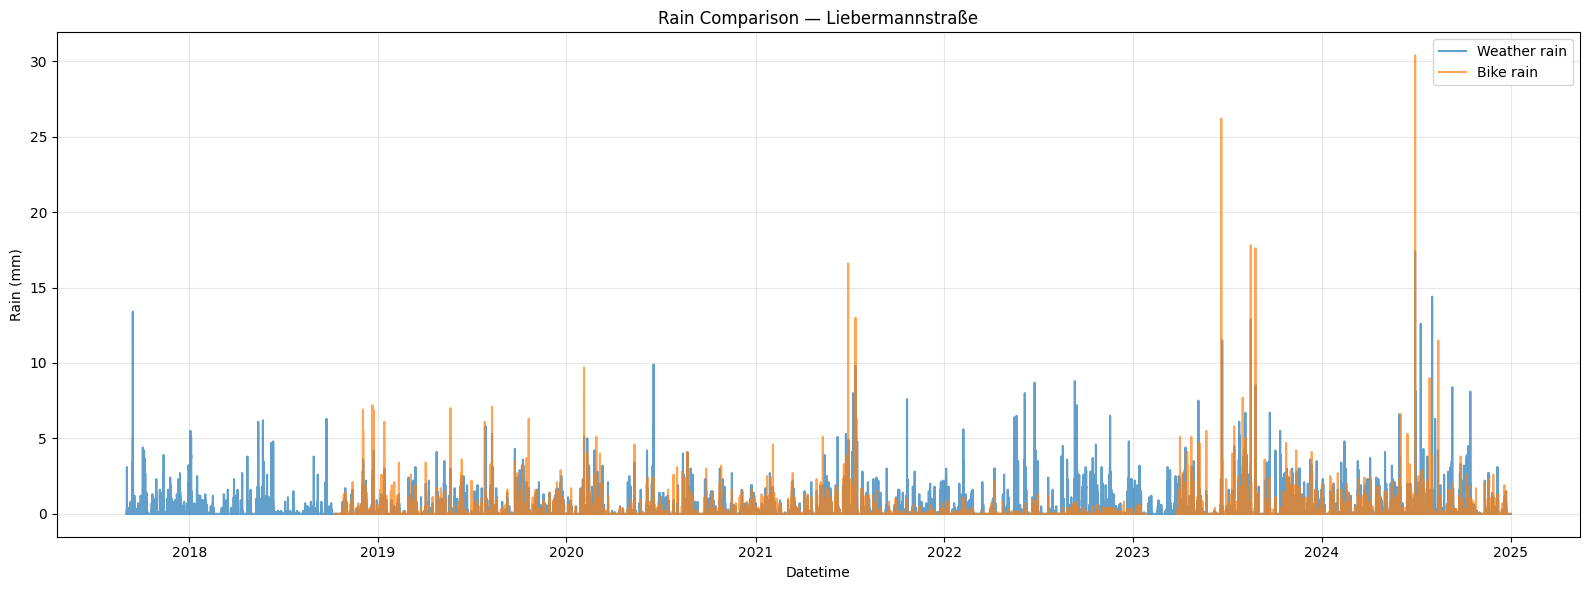

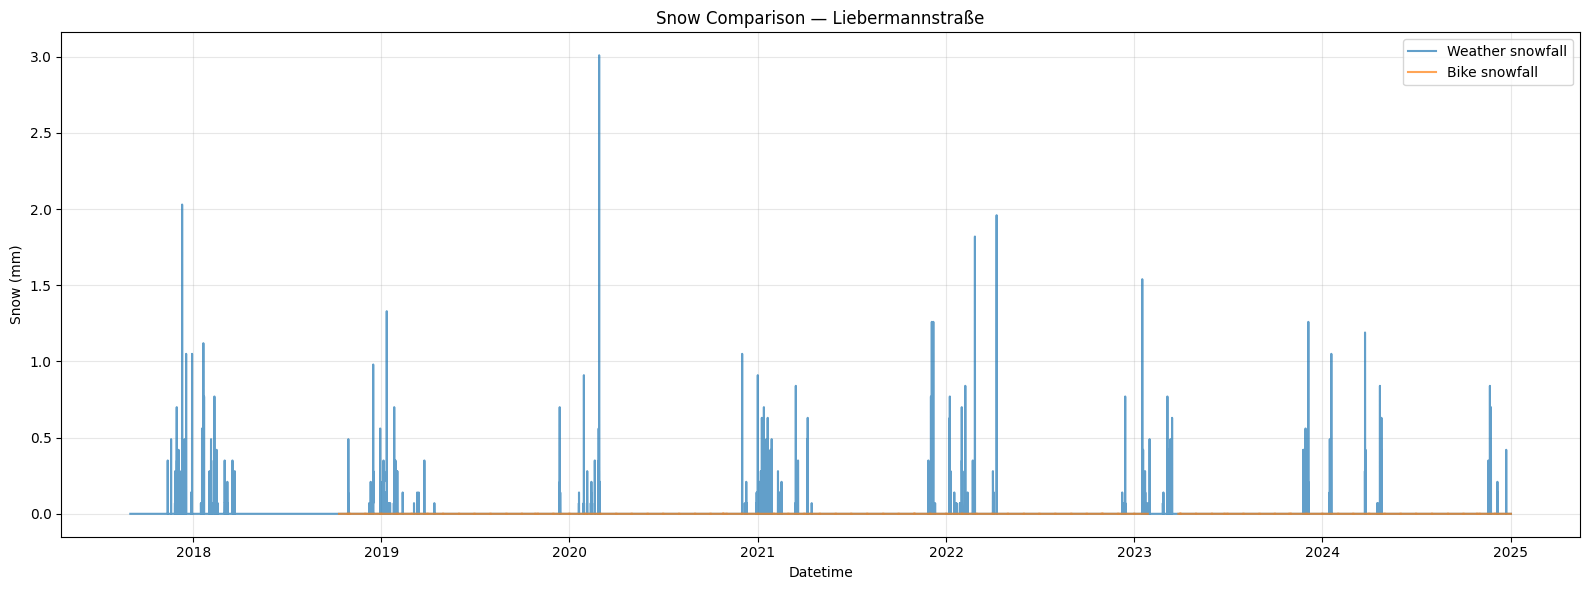

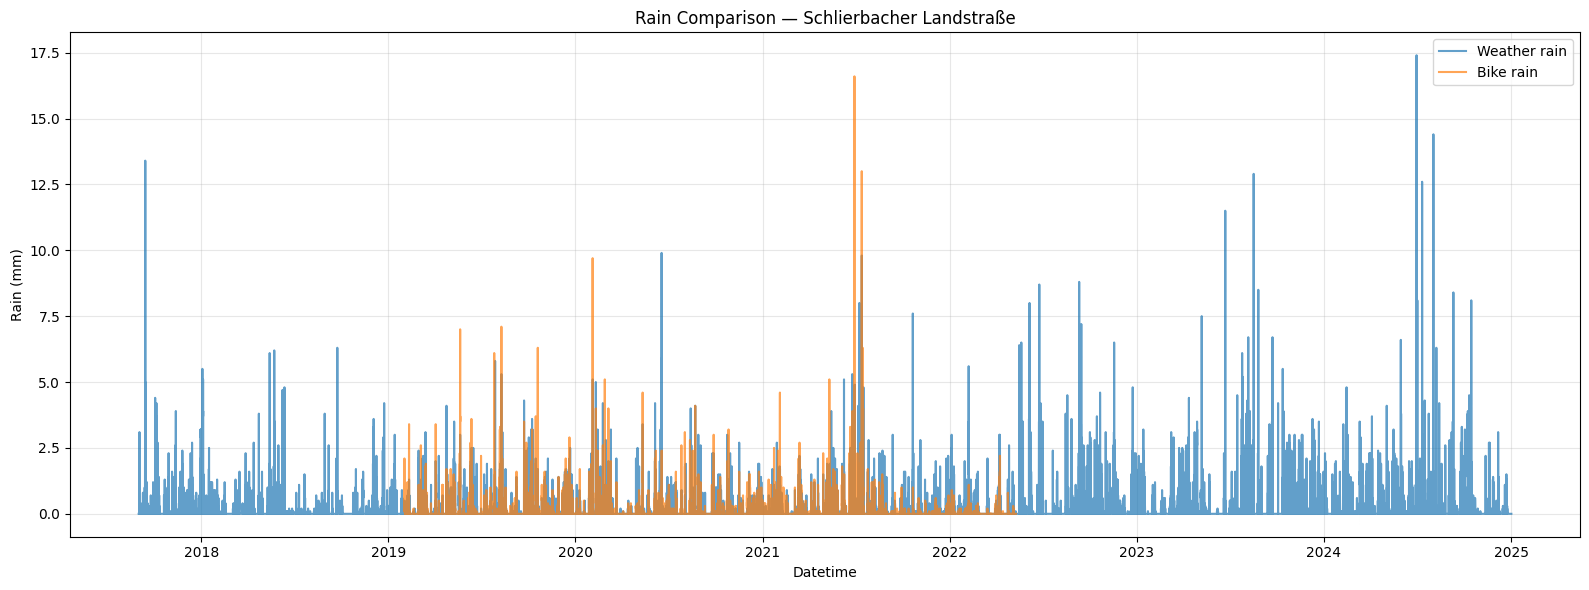

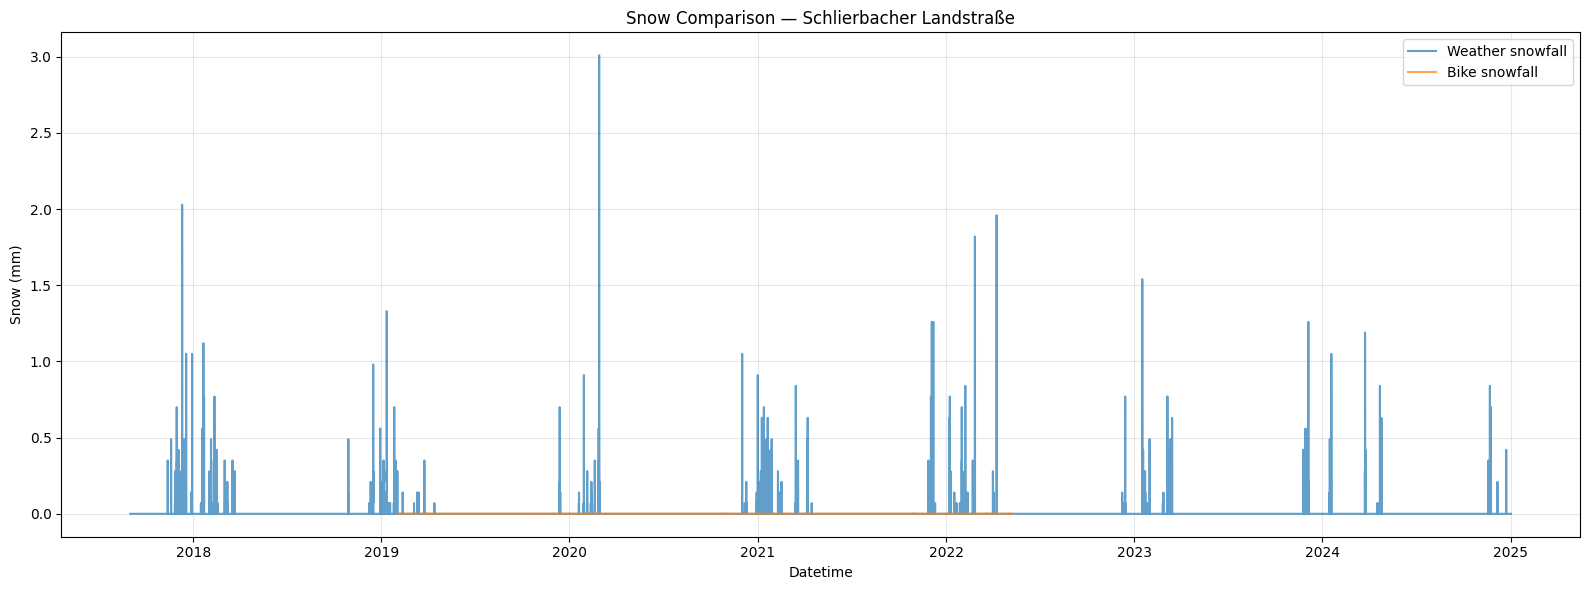

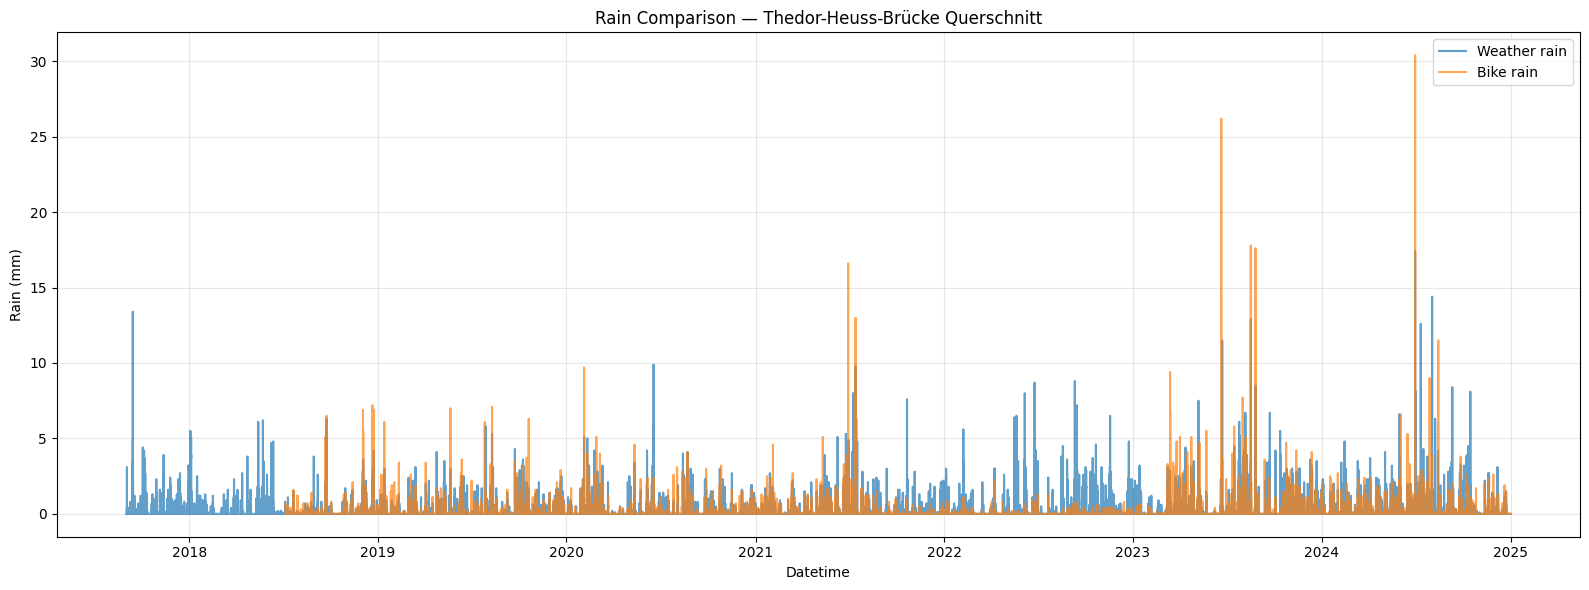

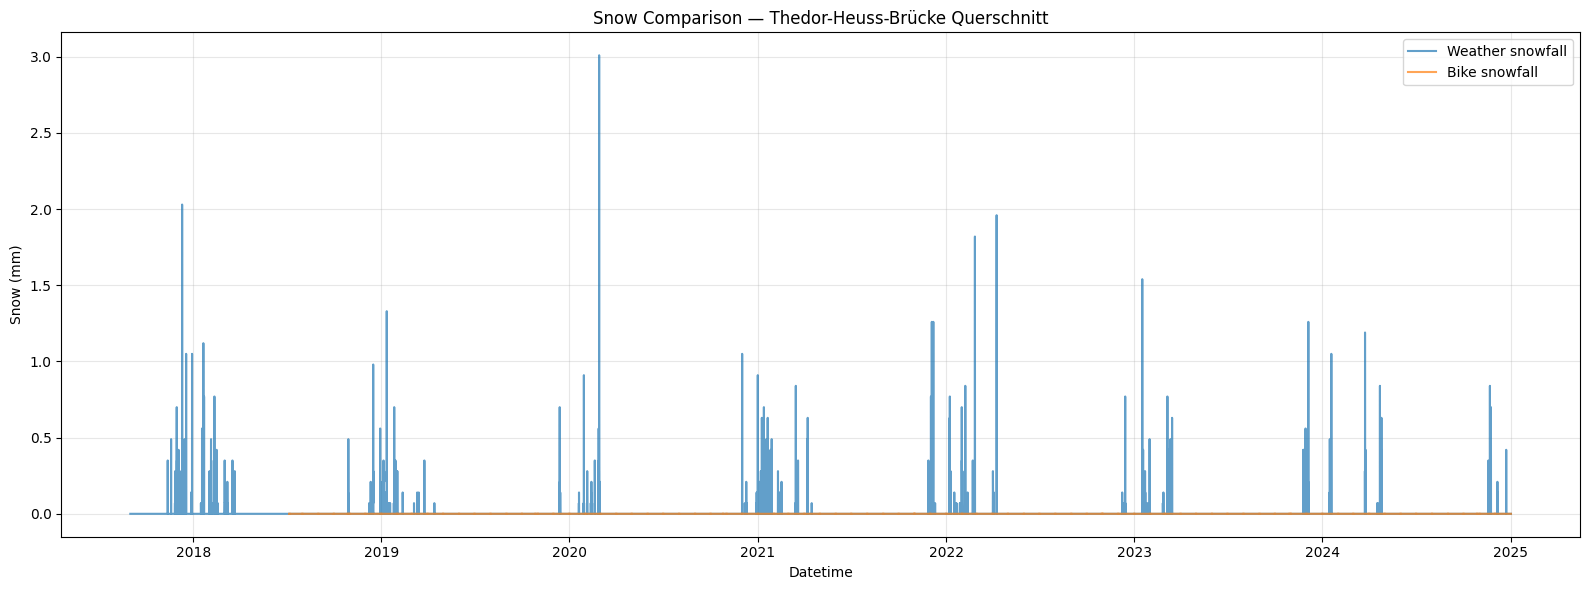

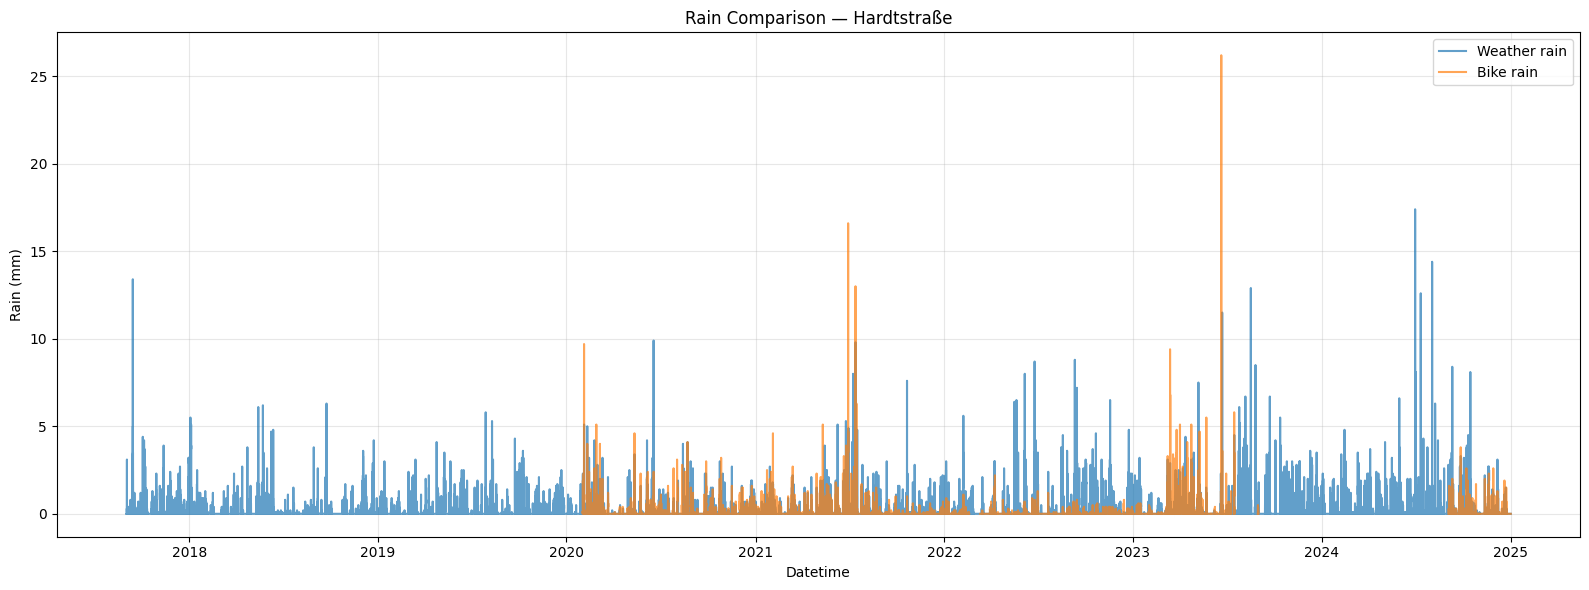

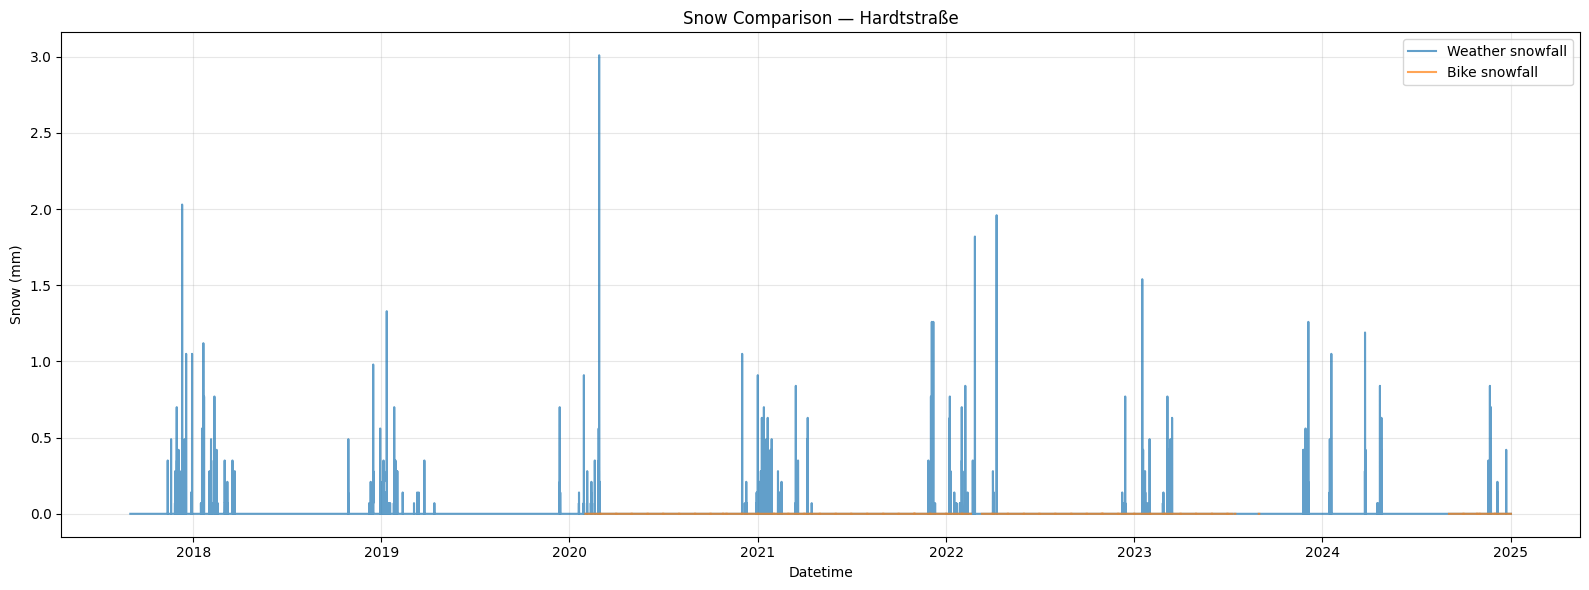

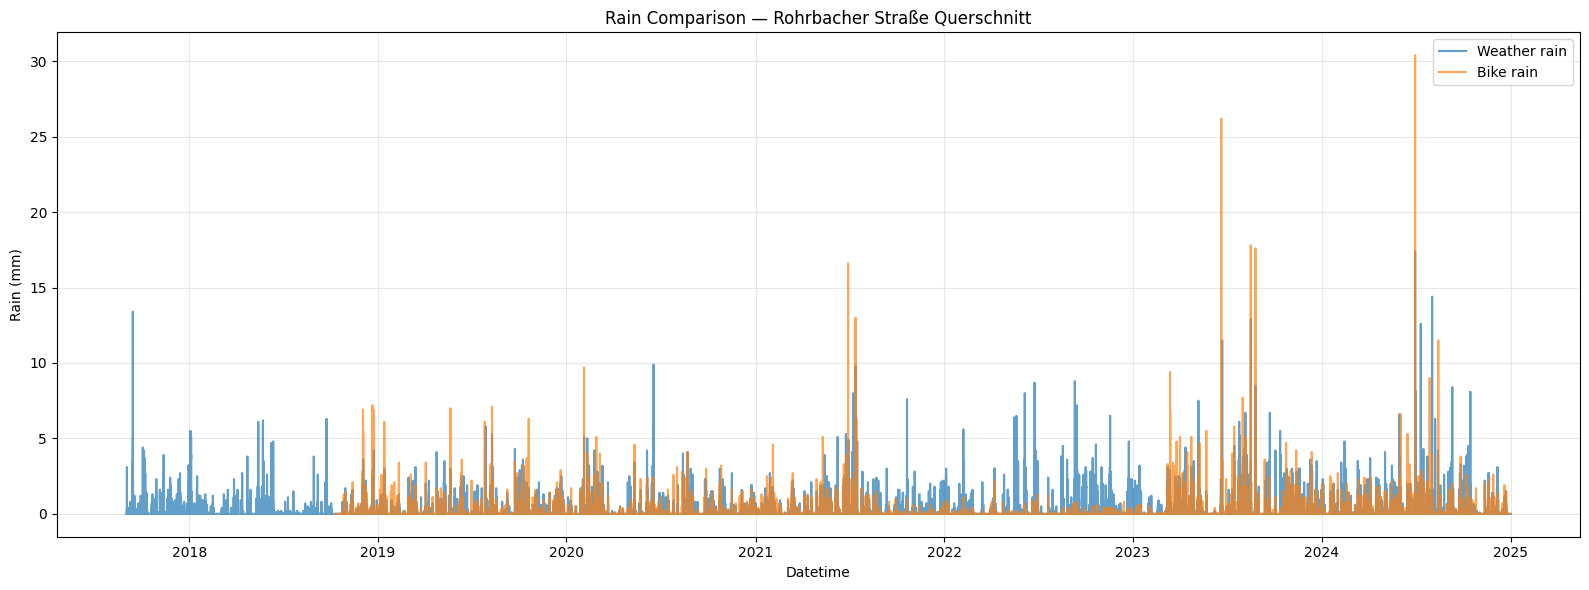

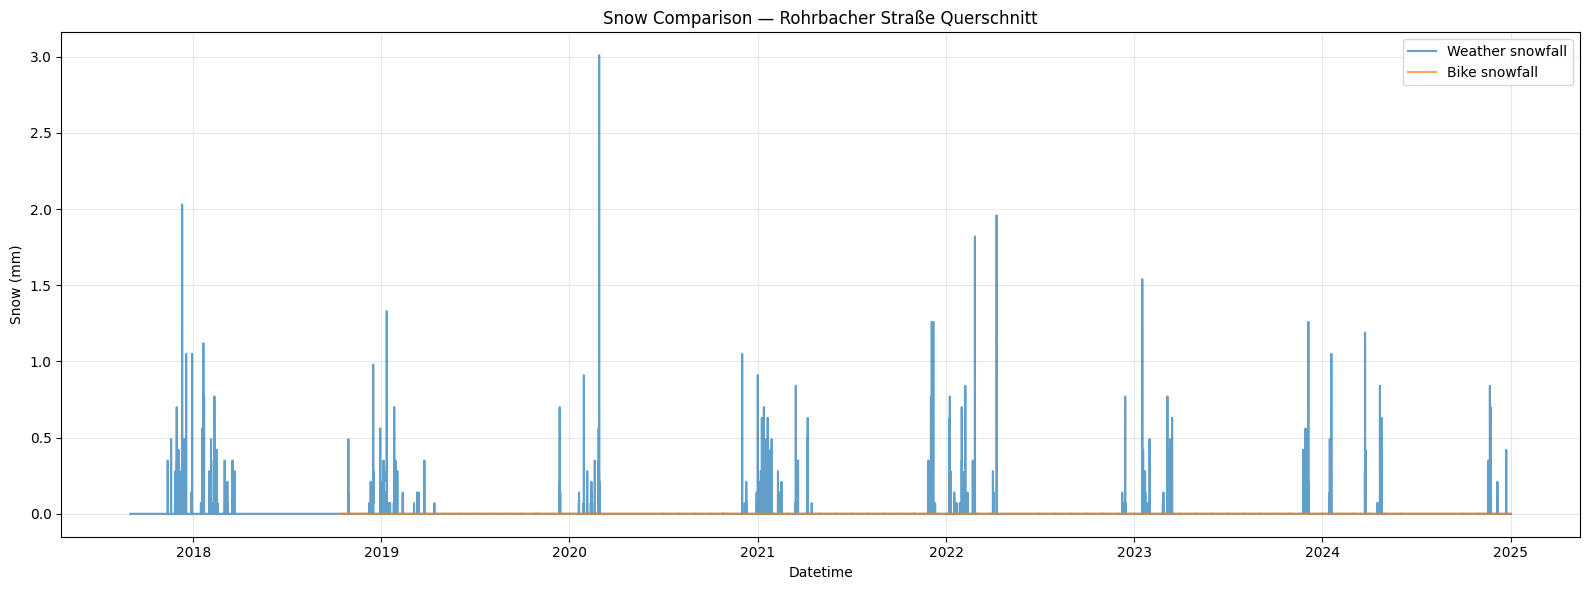

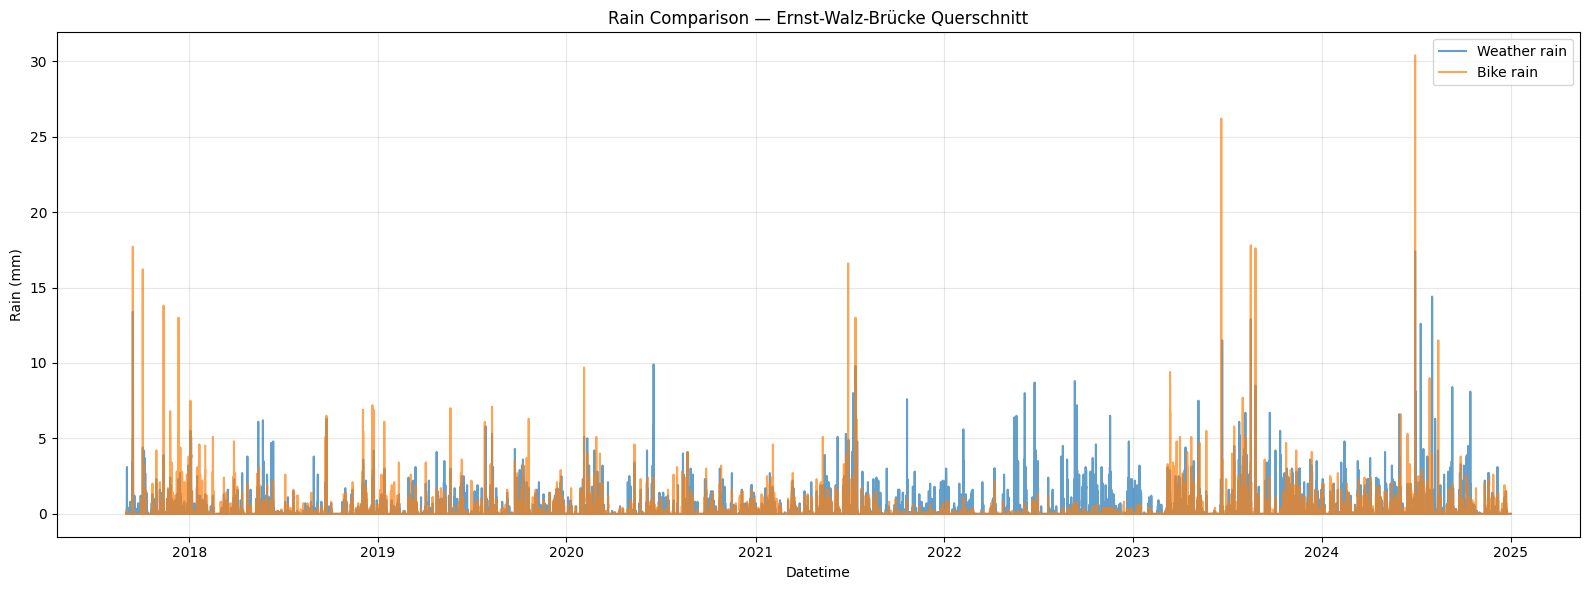

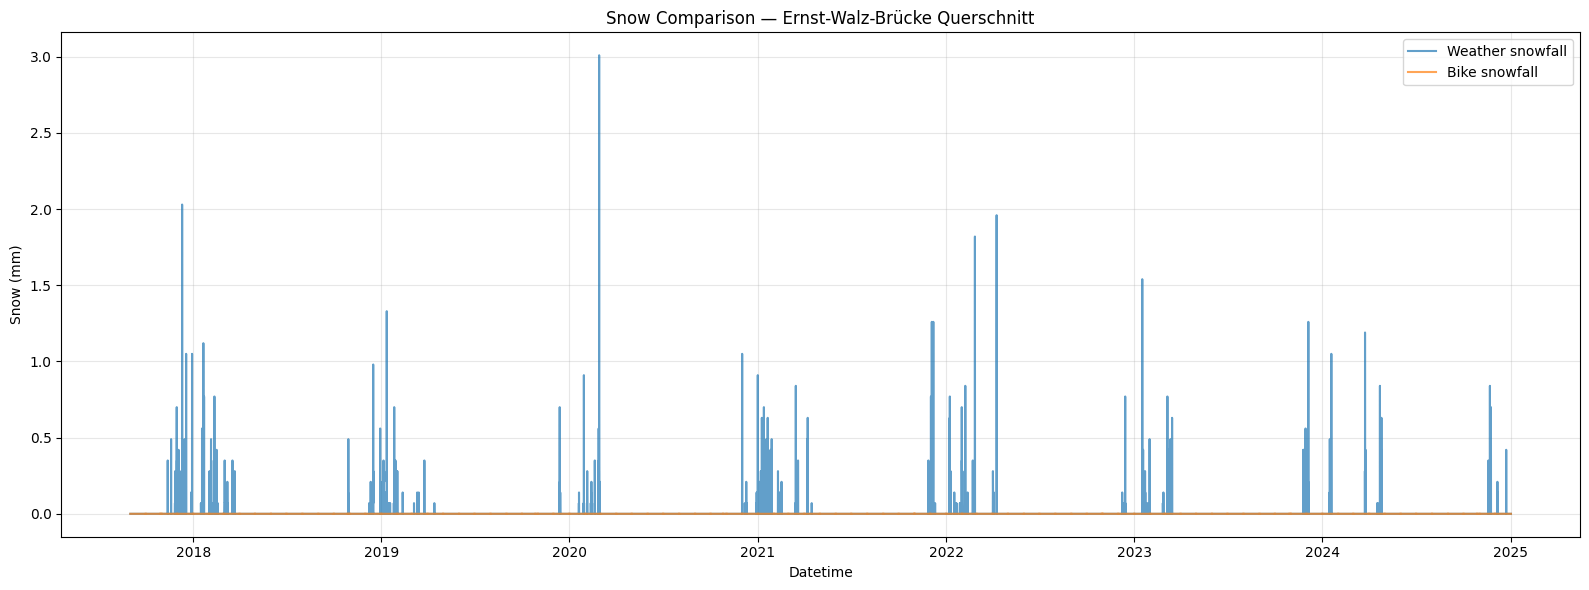

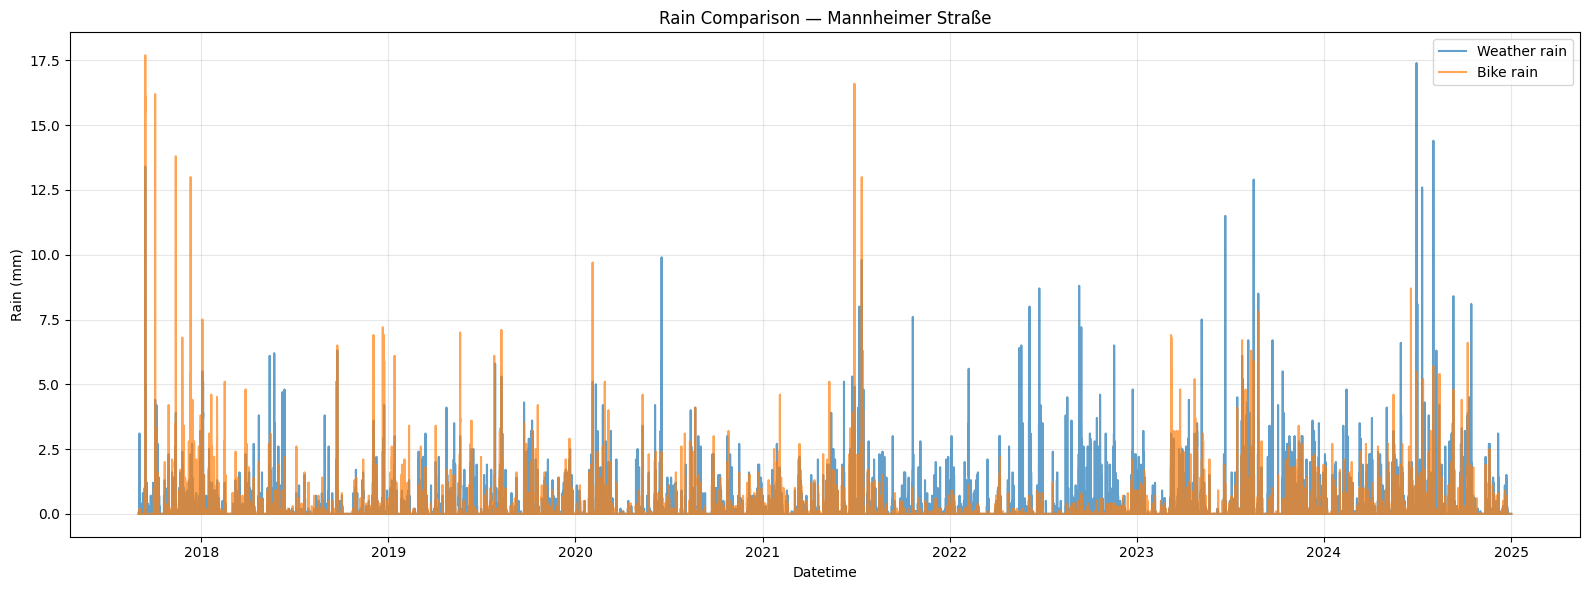

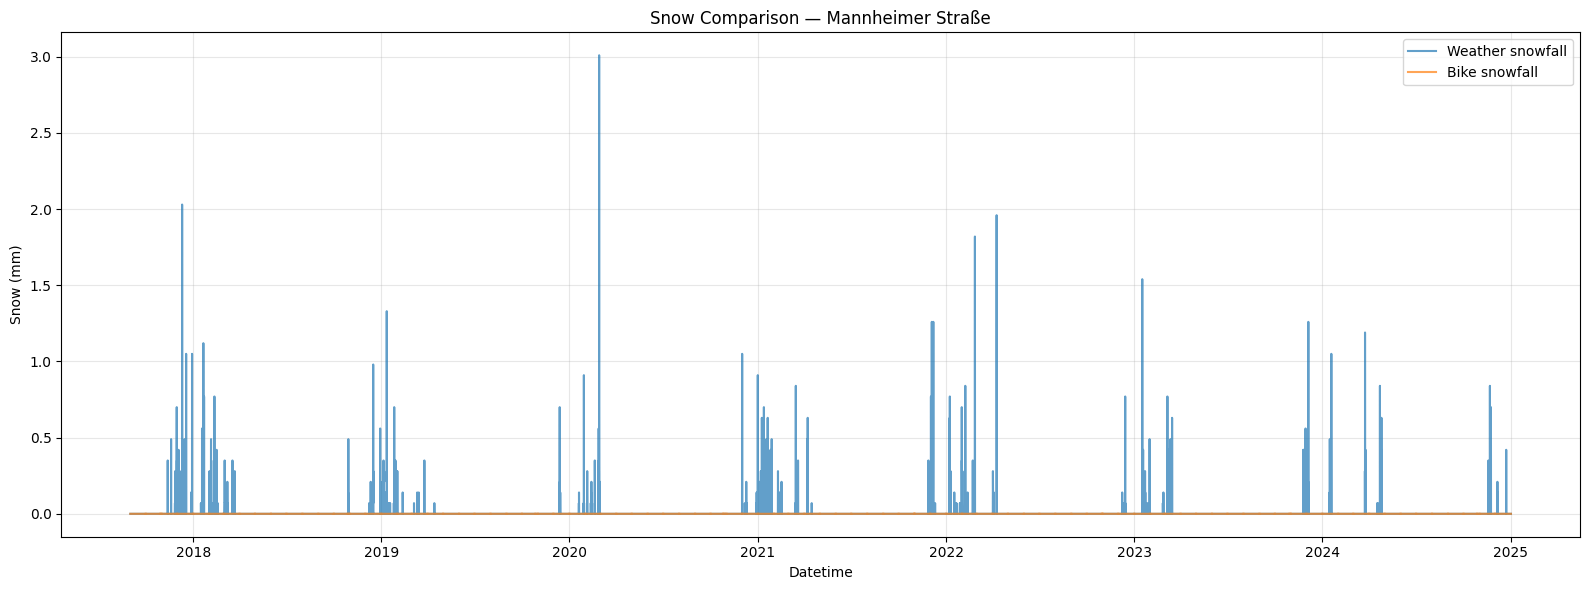

In [10]:
import matplotlib.pyplot as plt

def plot_precip_comparison(interval=("2017-09-01", "2026-10-10")):
    for station in dl.get_bicyle_stations():

        df = get_precip_diff(station, interval)

        plt.figure(figsize=(16,6))

        plt.plot(df["datetime"], df["rain"], label="Weather rain", alpha=0.7)
        plt.plot(df["datetime"], df["site_rain_accumulation"], label="Bike rain", alpha=0.7)

        plt.title(f"Rain Comparison — {station}")
        plt.xlabel("Datetime")
        plt.ylabel("Rain (mm)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(16,6))

        plt.plot(df["datetime"], df["snowfall"], label="Weather snowfall", alpha=0.7)
        plt.plot(df["datetime"], df["site_snow_accumulation"], label="Bike snowfall", alpha=0.7)

        plt.title(f"Snow Comparison — {station}")
        plt.xlabel("Datetime")
        plt.ylabel("Snow (mm)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
plot_precip_comparison()

<Figure size 1600x600 with 0 Axes>

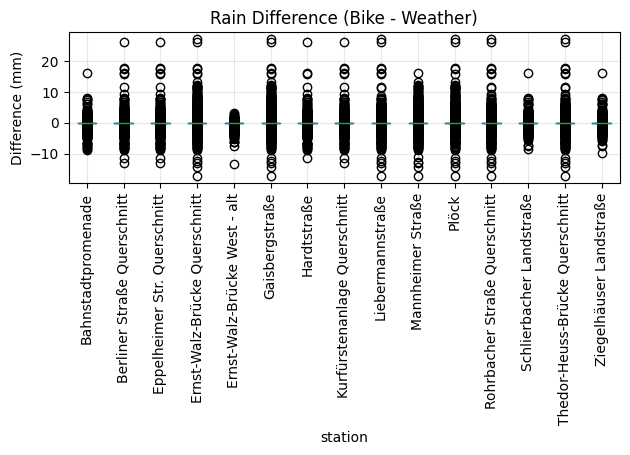

<Figure size 1600x600 with 0 Axes>

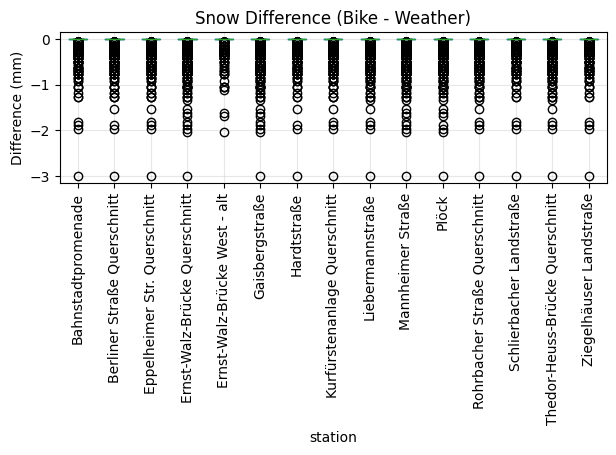

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def boxplot_precip_diff(interval=("2017-09-01", "2026-10-10")):
    rows_rain = []
    rows_snow = []

    for station in dl.get_bicyle_stations():
        df = get_precip_diff(station, interval)

        rows_rain.append(pd.DataFrame({
            "station": station,
            "rain_diff": df["rain_diff"].to_list()
        }))

        rows_snow.append(pd.DataFrame({
            "station": station,
            "snow_diff": df["snow_diff"].to_list()
        }))

    df_rain = pd.concat(rows_rain)
    df_snow = pd.concat(rows_snow)

    # Rain
    plt.figure(figsize=(16,6))
    df_rain.boxplot(by="station", column="rain_diff", rot=90)
    plt.suptitle("")
    plt.title("Rain Difference (Bike - Weather)")
    plt.ylabel("Difference (mm)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Snow
    plt.figure(figsize=(16,6))
    df_snow.boxplot(by="station", column="snow_diff", rot=90)
    plt.suptitle("")
    plt.title("Snow Difference (Bike - Weather)")
    plt.ylabel("Difference (mm)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
boxplot_precip_diff()